In [1]:
#!pip install torch

import numpy as np
import matplotlib.pyplot as plt
import torch

import warnings

In [2]:
# Import data from drive
from google.colab import drive, files
drive.mount('/content/drive/')
!ls "/content/drive/My Drive/413 Raw Data"


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
A.m4a  D.m4a  G.m4a  J.m4a  M.m4a  P.m4a  S.m4a		U.m4a  X.m4a
B.m4a  E.m4a  H.m4a  K.m4a  N.m4a  Q.m4a  SPACEBAR.m4a	V.m4a  Y.m4a
C.m4a  F.m4a  I.m4a  L.m4a  O.m4a  R.m4a  T.m4a		W.m4a  Z.m4a


In [ ]:
# Import audio management library
!pip install librosa
import librosa
import librosa.display

# Initial Data Processing


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


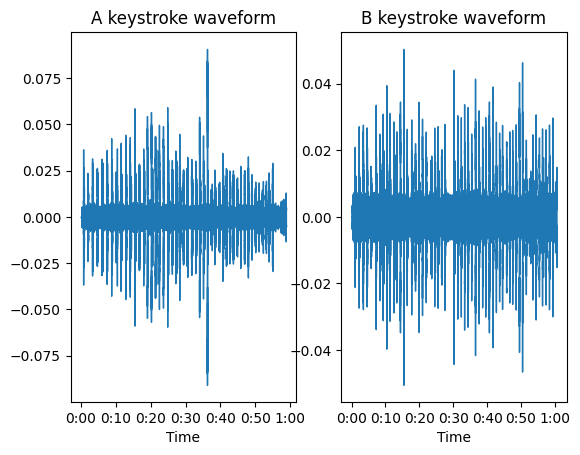

In [ ]:
warnings.filterwarnings('ignore')

fig, ax = plt.subplots(1, 2)
a_data, sr = librosa.load("./drive/MyDrive/413 Raw Data/A.m4a")
a_data, _ = librosa.effects.trim(a_data)
librosa.display.waveshow(a_data, sr=sr, ax=ax[0])

b_data, sr = librosa.load("./drive/MyDrive/413 Raw Data/B.m4a")
b_data, _ = librosa.effects.trim(b_data)
librosa.display.waveshow(b_data, sr=sr, ax=ax[1])

ax[0].set_title('A keystroke waveform')
ax[1].set_title('B keystroke waveform')

warnings.filterwarnings('once')

In order to distinguish the keystrokes, we will consier the power of the signal. Essentially, power is a measure of the energy of the signal, which we could naively do by looking at the maximum amplitude, but it is better to do so by looking at the integral. Given a signal $u(t)$, then the power of $u$ on the domain $[-t, t]$ is
$$\frac{1}{2t} \int_{-t}^t |u(s)|^2ds$$
We would like the power to be an increasing and positive function of the signal amplitude (i.e. a signal with very negative amplitude should still have high power, so we need to either square or look at the absolute value, the square makes things tractable).

Now in order to calculate this, we will do a discrete approximation by looking at the discrete fourier transform (DFT) and then using Parseval's theorem to get
$$\frac{1}{2t}\int_{-t}^t |u(s)|^2ds = \sum_{n \in \mathbb{Z}} |\hat{u}(n)|^2$$

We have to do apply the DFT to small windows in our sample, because we would like to distinguish areas of high vs low energy in the signal. See https://www.gaussianwaves.com/2013/12/power-and-energy-of-a-signal/ for more.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1295911 10124
(4097, 633)


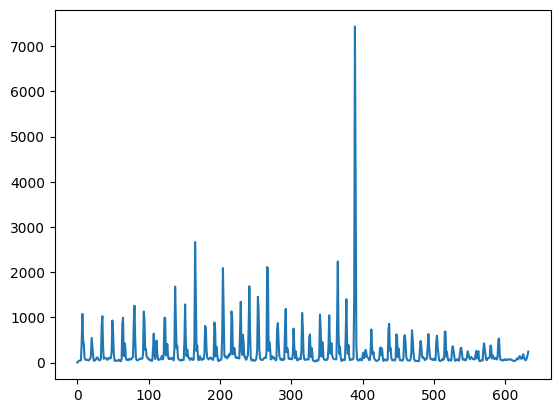

In [ ]:
hop_length = 2048 # should be a power of 2, good rule of thumb is n_fft / 4
n_fft = 8192 # should be a power of 2, this is about 0.37s in length

a_freq = librosa.core.stft(a_data, n_fft=n_fft, hop_length=hop_length)
# a_freq has shape  (1 + n_fft/2, n_frames), n_frames is going to be
# equal to the total number of samples / hop_length. In this case
print(a_data.size, a_data.size // 128)
print(a_freq.shape)
a_freq = np.abs(a_freq)
a_energy = np.sum(a_freq * a_freq, axis=0)
plt.plot(a_energy)

In [ ]:
def get_energy(waveform, n_fft=n_fft, hop_length=hop_length):
  wave_freq = librosa.core.stft(waveform, n_fft=n_fft, hop_length=hop_length)
  wave_freq = np.abs(wave_freq)
  wave_energy = np.sum(wave_freq * wave_freq, axis=0)
  return wave_energy

In [ ]:
# Calculate the mean energy
a_mean_energy = np.mean(a_energy)
print(f"Mean energy over all waveform: {a_mean_energy}")
a_std_energy = np.std(a_energy)
print(f"Standard deviation of energy of waveform: {a_std_energy}")
# There is a really low chance for noise to have this much energy
print(a_energy[a_energy > a_mean_energy + a_std_energy].size)
# 124 is more than expected (expect 50-100 segments)

Mean energy over all waveform: 240.95181274414062
Standard deviation of energy of waveform: 454.21331787109375
54


[  7  34  35  49  63  64  79  80  93  94 122 123 137 138 151 165 166 179
 180 192 193 204 205 216 217 228 229 240 241 242 253 254 266 267 280 281
 291 292 303 315 316 340 341 353 364 365 377 388 389 390 412 436 437 469]
[  32.28879  434.77237 1078.2533   488.99957  314.6257 ] 1078.2533


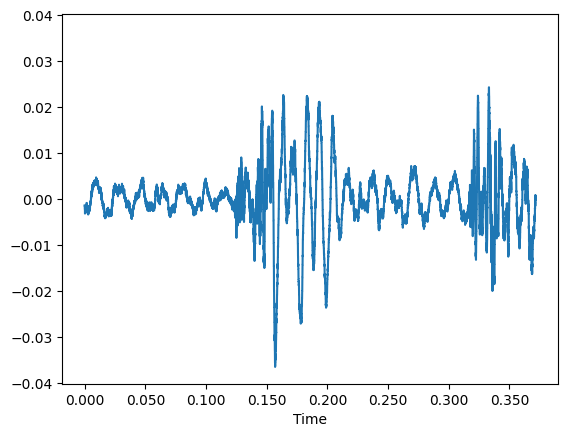

In [ ]:
high_energy_frames = np.nonzero(a_energy > a_mean_energy + a_std_energy)[0]
print(high_energy_frames)
start = high_energy_frames[0] * hop_length - hop_length * 2
end = start + n_fft
# This is size 5 because hop_length is 1/4 of n_fft and we always get at least 1 frame.
print(get_energy(a_data[start:end], n_fft, hop_length), a_energy[high_energy_frames[0]])

librosa.display.waveshow(a_data[start:end])
# looking good :)

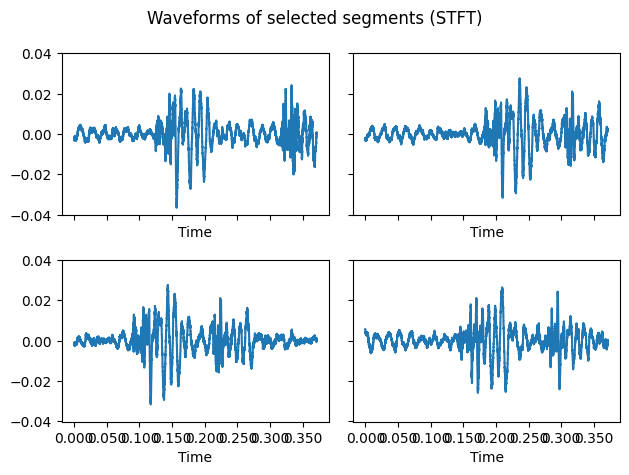

In [ ]:
class FFTSegmenter:
  """ A class to segment the audio waveforms into distinct keystrokes using STFT.
  """
  def __init__(self, sample_rate=22050, n_fft=8192, hop_length=2048):
    self.sr = sample_rate
    self.n_fft = n_fft
    self.hop_length = hop_length

  def __call__(self, waveform):
    # TODO: Improve by making sure the press down is not seperated from the
    # release, both will make noise.
    wave_energy = get_energy(waveform, self.n_fft, self.hop_length)
    mean_energy = np.mean(wave_energy)
    std_energy = np.std(wave_energy)
    high_energy = np.nonzero(wave_energy > mean_energy + std_energy)[0]
    start = high_energy * self.hop_length - (self.n_fft // self.hop_length) * self.hop_length // 2
    end = start + self.n_fft

    # Not sure how / if this can be vectorized, it's not too slow though
    segs = []
    for i in range(start.size):
      # Can't append right away because it might be shorter than
      # n_fft samples if it chooses a frame really close to the start or end
      candidate = waveform[start[i]:end[i]]
      if candidate.size == n_fft:
        segs.append(candidate)

    return np.array(segs)

fft_segmenter = FFTSegmenter()
segs = fft_segmenter(a_data)

fig, ax = plt.subplots(2, 2, sharey=True, sharex=True)
for i in range(2):
  for j in range(2):
    librosa.display.waveshow(y=segs[2 * i + j], ax=ax[i, j])
fig.suptitle("Waveforms of selected segments (STFT)")
fig.tight_layout()

We can also try to create segments by looking at the max absolute amplitude, and cutting segments if they are loud enough. This seems to perform worse in practice, which is presumably due to susceptibility to noise. The code below does the max amplitude segmentation and pads segments with Gaussian noise in order to get segments of uniform length.

On the other hand, this method does have benefits relative to using the fourier transform. Mainly that this is $O(n)$ and easily parallelizable, while the FFT is $O(n\log n)$. In this implementation, as the $O(n)$ method isn't parallelized, the FFT is just as fast while giving better performance. Additionally, our dataest isn't so huge that we need to worry about performance at this scale, so we will continue with the fourier method for the remainder of the code.

In [ ]:
def pad_with(vector, pad_width, iaxis, kwargs):
    pad_mean = kwargs.get('mean', 0)
    pad_std = kwargs.get('std', 0.001)
    left_size = pad_width[0]
    vector[:pad_width[0]] = np.random.normal(loc=pad_mean, scale=pad_std, size=(left_size,))

    right_size = vector.size - pad_width[1]
    vector[right_size:] = np.random.normal(loc=pad_mean, scale=pad_std, size=(pad_width[1],))

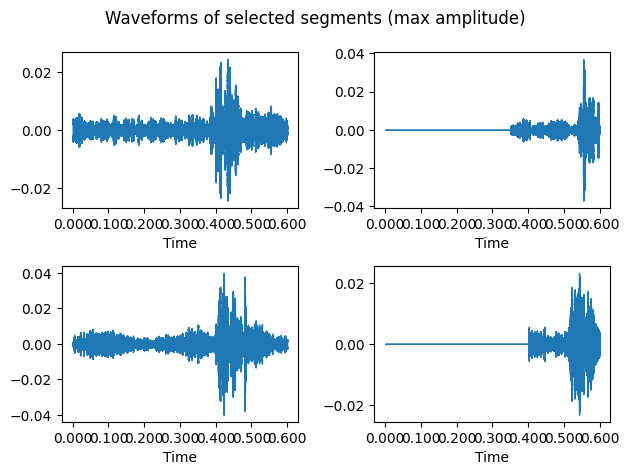

In [ ]:
class Segmenter:
  """ A class to segment the audio waveforms into distinct keystrokes.

  Iterates through the waveform and segments the data as soon as it runs into
  a noise > audio_threshold.
  """
  def __init__(self, sample_rate=22050, audio_threshold=0.015, hop_length=200, segment_length=1000):
    """ Initialize the Segmenter.

    Parameters:
    sample_rate:     the sample rate of the waveform, the default value is 22050 which is the
                     default used by Librosa
    audio_threshold: If the segmenter hears audio at least as loud as this, it will create a new
                     segment. I.e. anything less than this is considered background noise.
    hop_length:      Controls the granularity of the search. Smaller hop_length will decrease
                     the chance of grouping keystrokes together, at the expense of more 0 padding.
    segment_length:  The length of the outputted segments. Segments may be padded with 0s.
    """
    self.sample_rate = sample_rate
    self.hop_length = hop_length
    self.hop_length_sample = int(22050 / 1000 * hop_length)
    self.segment_length_sample = int(22050 / 1000 * segment_length)
    self.audio_threshold = audio_threshold

  def get_noise_level(self, waveform, start: int, end: int):
    return np.max(np.abs(waveform[start:end]))

  def __call__(self, waveform: np.array):
    length = int(waveform.size)
    segments = []

    curr_sample = self.hop_length_sample
    last_sample = 0

    curr_peaks = 0
    while curr_sample < length:
      # To avoid cutting off a segment too early, check only the middle 60%
      dt = curr_sample - last_sample
      start = int(last_sample + 0.15 * dt)
      end = int(curr_sample - 0.15 * dt)

      sample_noise = self.get_noise_level(waveform, start, end)
      if sample_noise > self.audio_threshold:
        curr_peaks += 1
        if curr_peaks < 10:
          pass
        # Take only the last 1 second of samples
        if dt > self.segment_length_sample:
          segments.append(waveform[curr_sample-self.segment_length_sample:curr_sample])
        # Pad the array with 0s to get up to 1 second
        if dt <= self.segment_length_sample:
          seg = np.pad(waveform[last_sample:curr_sample], (self.segment_length_sample - dt, 0))
          #seg = np.pad(waveform[last_sample:curr_sample], (self.segment_length_sample - dt, 0), pad_with)
          segments.append(seg)
        last_sample = curr_sample
      curr_sample += self.hop_length_sample

    return segments


segmenter = Segmenter(audio_threshold=0.02, hop_length=50, segment_length=600)
segs = segmenter(a_data)

fig, ax = plt.subplots(2, 2)
for i in range(2):
  for j in range(2):
    librosa.display.waveshow(segs[2 * i + j + 10], ax=ax[i, j])

fig.suptitle("Waveforms of selected segments (max amplitude)")
fig.tight_layout()


(128, 17)
(128, 17)
(128, 17)
(128, 17)


/usr/local/lib/python3.10/dist-packages/librosa/display.py:859: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return mcm.get_cmap(cmap_seq)


Text(0.5, 0.98, 'Mel-frequency spectrograms of selected segments (STFT)')

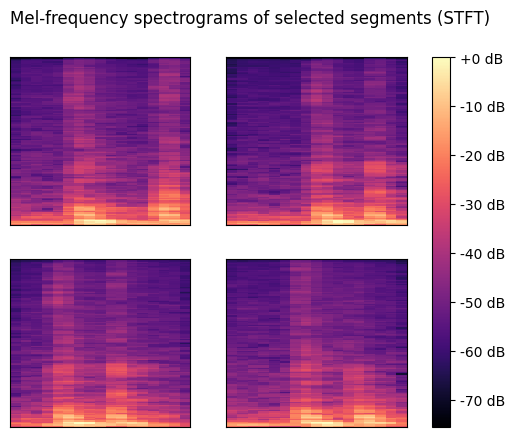

In [ ]:
fig, ax = plt.subplots(2, 2)
segs = fft_segmenter(a_data)

for i in range(2):
  for j in range(2):
    spec = librosa.feature.melspectrogram(y=segs[2 * i + j], n_mels=128)
    spec_dB = librosa.power_to_db(spec, ref=np.max)
    img = librosa.display.specshow(spec_dB, ax=ax[i, j])
    print(spec_dB.shape)#

fig.colorbar(img, ax=ax.ravel().tolist(), format='%+2.0f dB')
fig.suptitle('Mel-frequency spectrograms of selected segments (STFT)')

Completed key: A
Completed key: B
Completed key: C
Completed key: D
Completed key: E
Completed key: F
Completed key: G
Completed key: H
Completed key: I
Completed key: J
Completed key: K
Completed key: L
Completed key: M
Completed key: N
Completed key: O
Completed key: P
Completed key: Q
Completed key: R
Completed key: S
Completed key: T
Completed key: U
Completed key: V
Completed key: W
Completed key: X
Completed key: Y
Completed key: Z
Completed key: SPACEBAR


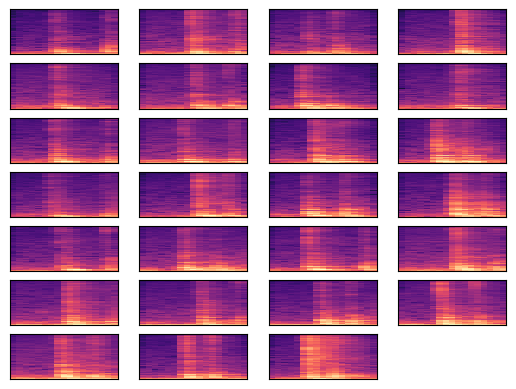

In [ ]:
keys = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
keys.append('SPACEBAR')

fig, ax = plt.subplots(7, 4)
data = None
targets = None
segs = None

# avoid getting a bunch of deprecation warnings which are not helpful
warnings.filterwarnings('ignore')

segmenter = FFTSegmenter()
for n, key in enumerate(keys):
  filepath = "./drive/MyDrive/413 Raw Data/" + key + ".m4a"
  key_data, sr = librosa.load(filepath)
  # segment using Segmenter class
  key_segs = segmenter(key_data)
  # Create Mel-Spectrogram and convert to dB
  key_spec = librosa.feature.melspectrogram(y=key_segs)
  key_spec = librosa.power_to_db(key_spec, ref=np.max)

  # Keep track of audio waveform data too
  if segs is None:
    segs = key_segs
  else:
    segs = np.concatenate((segs, key_segs), axis=0)

  # Add to current data
  if data is None:
    data = key_spec
    targets = np.full((key_spec.shape[0], 27), 0)
    targets[:, n] = 1
  else:
    data = np.concatenate((data, key_spec), axis=0)
    key_targets = np.full((key_spec.shape[0], 27), 0)
    key_targets[:, n] = 1
    targets = np.concatenate((targets, key_targets), axis=0)
  print(f"Completed key: {key}")

  img = librosa.display.specshow(key_spec[0], ax=ax[n // 4, n % 4])

ax[-1, -1].axis('off')
# Turn warnings back on
warnings.filterwarnings('once')

In [ ]:
# Each Mel-Spectrogram is size (128, 26), we have 2752 spectrograms in our data
print(segs.shape)
print(data.shape)
print(targets.shape)

(2752, 8192)
(2752, 128, 17)
(2752, 27)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Data Augmentation

There are many ways to augment audio data (see https://towardsdatascience.com/data-augmentation-techniques-for-audio-data-in-python-15505483c63c). The methods listed in the article are:

1.   Noise injection
2.   Time Shift
3.   Acceleration / Deceleration
4.   Change the pitch
5.   Mixup (averaging)
6.   SpecAugment

The first four techniques are applied to the time domain data (before conversion to spectrogram) and the last two are applied to the spectrograms.

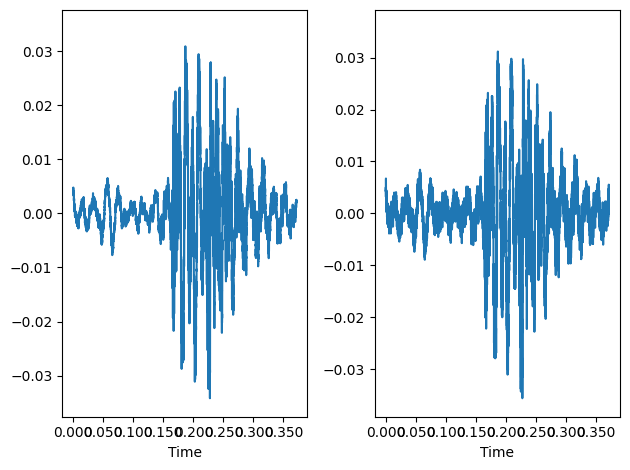

In [ ]:
def inject_noise(waveform, target, scale: float):
  """ Injects white noise into the provided waveform with amplitude of 'scale'.
  """
  if len(waveform.shape) == 2:
    d1, d2 = waveform.shape
    return (waveform + np.random.randn(d1, d2) * scale, target)
  else:
    return (waveform + np.random.randn(waveform.size) * scale, target)

fig, ax = plt.subplots(1, 2)
librosa.display.waveshow(segs[-1], ax=ax[0])
librosa.display.waveshow(inject_noise(segs[-1], 0, 0.001)[0], ax=ax[1])
fig.tight_layout()

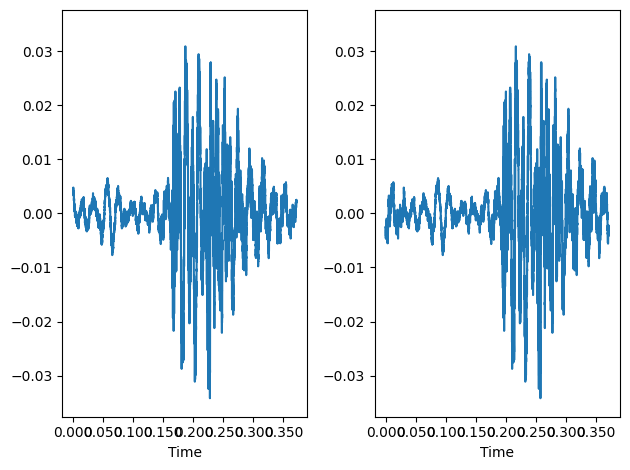

In [ ]:
def time_shift(waveform, target, t: float, sr: int = 22050):
  """ Shifts (cyclically) the provided waveform by t milliseconds.
  """
  shift = int(t * sr / 1000)
  return (np.roll(waveform, shift), target)

fig, ax = plt.subplots(1, 2)
librosa.display.waveshow(segs[-1], ax=ax[0])
librosa.display.waveshow(time_shift(segs[-1], 0, 30)[0], ax=ax[1])
fig.tight_layout()

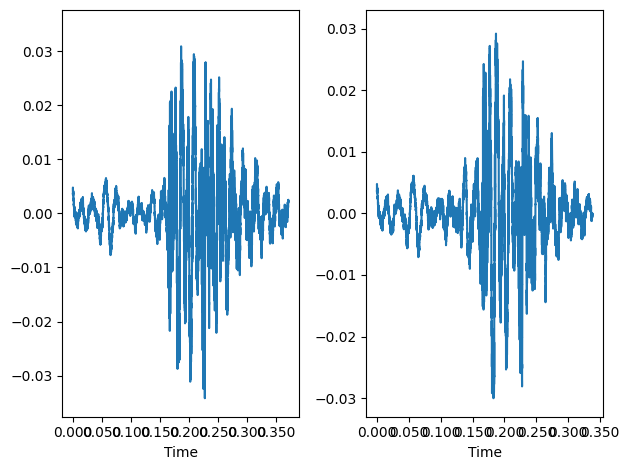

In [ ]:
def time_dilation(waveform, target, d):
  """ Dilates the provided waveform by d. I.e. d = 2 means the returned waveform will be twice as fast.

  Returned waveform is NOT the same shape as the original.
  """
  return (librosa.effects.time_stretch(y=waveform, rate=d), target)

fig, ax = plt.subplots(1, 2)
librosa.display.waveshow(segs[-1], ax=ax[0])
librosa.display.waveshow(time_dilation(segs[-1], 0, 1.1)[0], ax=ax[1])
fig.tight_layout()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


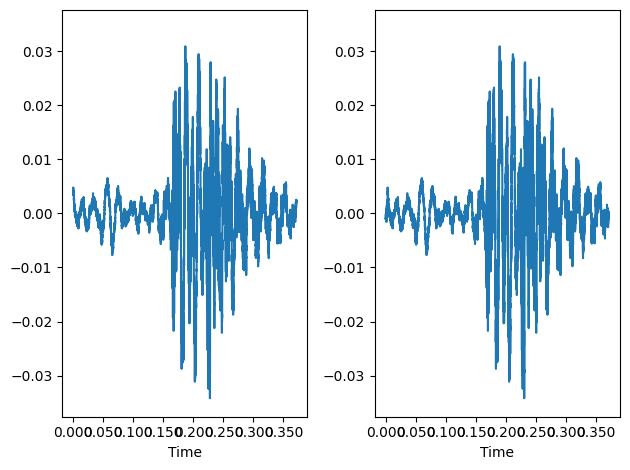

In [ ]:
def pitch_shift(waveform, target, n_qtones: float, sr:int = 22050):
  """ Changes the pitch of the waveform by n_qtones quarter tones.
  """
  return (librosa.effects.pitch_shift(y=waveform, n_steps=n_qtones, sr=sr, bins_per_octave=24), target)

fig, ax = plt.subplots(1, 2)
librosa.display.waveshow(segs[-1], ax=ax[0])
librosa.display.waveshow(time_shift(segs[-1], 0, 3)[0], ax=ax[1])
fig.tight_layout()

(array([ 0, 23]),)
(array([0, 3]),)
(array([ 0, 12]),)
(array([0, 4]),)
(array([0, 1]),)
(array([ 0, 22]),)


/usr/local/lib/python3.10/dist-packages/librosa/display.py:861: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return mcm.get_cmap(cmap_div)


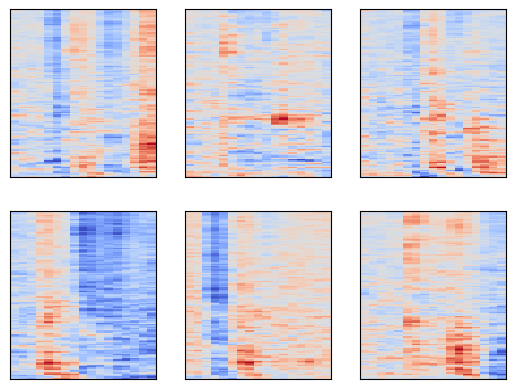

In [ ]:
# Code copied from https://towardsdatascience.com/data-augmentation-techniques-for-audio-data-in-python-15505483c63c#6c42

# TODO: Change a little bit so that there is different random choice every now and then
def mixup(original_melspecs, original_labels, alpha=1.0):
    indices = torch.randperm(original_melspecs.shape[0])

    lam = np.random.beta(alpha, alpha)

    augmented_melspecs = original_melspecs * lam + original_melspecs[indices] * (1 - lam)
    augmented_labels = (original_labels * lam) + (original_labels[indices] * (1 - lam))

    return augmented_melspecs, augmented_labels

mix, mix_label = mixup(data[:, :, :], targets[:, :])

fig, ax = plt.subplots(2, 3)
for i in range(6):
  librosa.display.specshow(data[i, :, :] - mix[i, :, :], ax=ax[i // 3, i % 3])
  print(np.nonzero(mix_label[i, :] > 0))

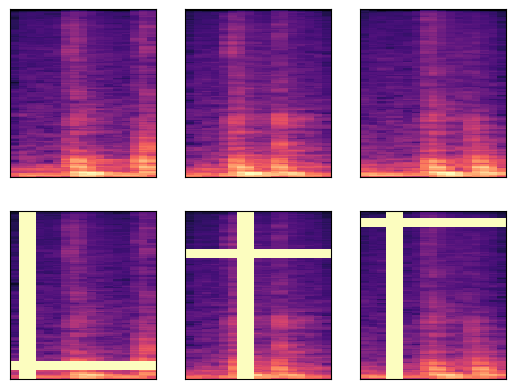

In [ ]:
# Code copied from  https://towardsdatascience.com/data-augmentation-techniques-for-audio-data-in-python-15505483c63c#6c42
def spec_augment(original_melspecs,
                 targets,
                 freq_masking_max_percentage = 0.15,
                 time_masking_max_percentage = 0.3):

    augmented_melspecs = original_melspecs.copy()
    b, all_frames_num, all_freqs_num = augmented_melspecs.shape

    # Frequency masking
    freq_percentage = np.random.uniform(0.0, freq_masking_max_percentage)
    num_freqs_to_mask = int(freq_percentage * all_freqs_num)
    f0 = np.random.uniform(low = 0.0, high = (all_freqs_num - num_freqs_to_mask), size=b).astype(int)

    # Time masking
    time_percentage = np.random.uniform(0.0, time_masking_max_percentage)
    num_frames_to_mask = int(time_percentage * all_frames_num)
    t0 = np.random.uniform(low = 0.0, high = (all_frames_num - num_frames_to_mask), size=b).astype(int)

    for k in range(b):
      augmented_melspecs[k, :, f0[k]:(f0[k] + num_freqs_to_mask)] = 0
      augmented_melspecs[k, t0[k]:(t0[k] + num_frames_to_mask), :] = 0

    return augmented_melspecs, targets

fig, ax = plt.subplots(2, 3)
augmented, _ = spec_augment(data, targets)

# Print the unaugmented ones
for i in range(3):
  librosa.display.specshow(data[i, :, :], ax=ax[0, i])
# Print augmented
for i in range(3):
  librosa.display.specshow(augmented[i, :, :], ax=ax[1, i])

In [ ]:
from tqdm import trange

# TODO: Consider whether this much augmentation is a good idea. In the paper we're
# trying to reproduce, they only do some time shifting (with much bigger shifts than we do)
# and then spec augment. They do not do any pitch shift, noise-injection, or mixup.

train_segs = segs[:2000]
train_targets = targets[:2000]

test_segs = segs[2000:]
test_targets = targets[2000:]

# Now add in time-shift to a % of the data
N = train_segs.shape[0]
for i in trange(N // 3):
  t = np.random.randint(1, 31)
  idx = np.random.randint(0, N)
  noisy, target = time_shift(train_segs[idx, :], train_targets[idx, :], t)
  noisy = noisy.reshape(1, -1)
  target = target.reshape(1, -1)
  train_segs = np.concatenate((train_segs, noisy), axis=0)
  train_targets = np.concatenate((train_targets, target), axis=0)

# Now do pitch shift
N = train_segs.shape[0]
for i in trange(N // 3):
  n_qtones = np.random.randint(1, 4)
  idx = np.random.randint(0, N)
  noisy, target = pitch_shift(train_segs[idx, :], train_targets[idx, :], n_qtones)
  noisy = noisy.reshape(1, -1)
  target = target.reshape(1, -1)
  train_segs = np.concatenate((train_segs, noisy), axis=0)
  train_targets = np.concatenate((train_targets, target), axis=0)

# Add noise injection
scale = 0.001
noisy, target = inject_noise(train_segs, train_targets, scale)
train_segs = np.concatenate((train_segs, noisy), axis=0)
train_targets = np.concatenate((train_targets, target), axis=0)
print(train_segs.shape, train_targets.shape)

# Convert everything to MelSpec.
train_data = librosa.feature.melspectrogram(y=train_segs)
train_data = librosa.power_to_db(train_data, ref=np.max)
print(train_data.shape)
test_data = librosa.feature.melspectrogram(y=test_segs)
test_data = librosa.power_to_db(test_data, ref=np.max)

# Now mixup
noisy, target = mixup(train_data, train_targets)
train_data = np.concatenate((train_data, noisy), axis=0)
train_targets = np.concatenate((train_targets, target), axis=0)

# Finally SpecAugment
noisy, target = spec_augment(train_data, train_targets)
train_data = np.concatenate((train_data, noisy), axis=0)
train_targets = np.concatenate((train_targets, target), axis=0)

print(train_data.shape, train_targets.shape)

100%|██████████| 888/888 [00:40<00:00, 22.18it/s]


(7108, 8192) (7108, 27)
(7108, 128, 17)
(28432, 128, 17) (28432, 27)


In [ ]:
np.save("drive/MyDrive/train_data.npy", train_data)
np.save("drive/MyDrive/train_targets.npy", train_targets)
np.save('drive/MyDrive/test_data.npy', test_data)
np.save('drive/MyDrive/test_targets.npy', test_targets)

In [ ]:
!ls "drive/MyDrive/" -l | grep ".npy"

-rw------- 1 root root 681279616 Apr 13 02:43 data.npy
-rw------- 1 root root   8453504 Apr 13 02:43 targets.npy
-rw------- 1 root root   6545536 Apr 15 16:42 test_data.npy
-rw------- 1 root root    162560 Apr 15 16:42 test_targets.npy
-rw------- 1 root root 494944384 Apr 15 16:42 train_data.npy
-rw------- 1 root root   6141440 Apr 15 16:42 train_targets.npy


# Training Initial Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models, torchvision.datasets
import torchvision.transforms as transforms
warnings.filterwarnings('once')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

perm = np.random.permutation(train_data.shape[0])
train_data = train_data[perm]
train_targets = train_targets[perm]
train_data = train_data.reshape(-1, 1, 128, 17)
test_data = test_data.reshape(-1, 1, 128, 17)

valid_data = train_data[23000:, :, :]
valid_targets = train_targets[23000:, :]

train_data = train_data[:23000, :, :]
train_targets = train_targets[:23000, :]

NameError: name 'train_data' is not defined

In [ ]:
train_data_tensor = torch.utils.data.TensorDataset(torch.tensor(train_data).to(device), torch.tensor(train_targets).to(device))
valid_data_tensor = torch.utils.data.TensorDataset(torch.tensor(valid_data).to(device), torch.tensor(valid_targets).to(device))
test_data_tensor = torch.utils.data.TensorDataset(torch.tensor(test_data).to(device), torch.tensor(test_targets).to(device))

train_data_loader = torch.utils.data.DataLoader(train_data_tensor, batch_size=64, shuffle=True)
dbatch, tbatch = next(iter(train_data_loader))
print(dbatch.shape, tbatch.shape)

torch.Size([64, 1, 128, 17]) torch.Size([64, 27])


In [ ]:
class CNN(nn.Module):
  """ Copied straight from ChatGPT

  TODO: Can improve by using weight decay.
  """
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1).double()
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1).double()
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1).double()
    self.bn1 = nn.BatchNorm2d(16).double()
    self.bn2 = nn.BatchNorm2d(32).double()
    self.bn3 = nn.BatchNorm2d(64).double()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    self.fc1 = nn.Linear(64 * 16 * 2, 128).double()
    self.fc2 = nn.Linear(128, 27).double()

  def forward(self, x):
    x = self.bn1(self.pool(torch.relu(self.conv1(x))))
    x = self.bn2(self.pool(torch.relu(self.conv2(x))))
    x = self.bn3(self.pool(torch.relu(self.conv3(x))))
    x = torch.flatten(x, 1)
    x = torch.relu(self.fc1(x))
    x = self.fc2(x)
    return x



In [3]:
# Training code copied from lab 05.
def get_accuracy(model, data, device="cuda"):
    loader = torch.utils.data.DataLoader(data, batch_size=256)
    model.to(device)
    model.eval() # annotate model for evaluation (important for batch normalization)
    correct = 0
    total = 0
    for imgs, labels in loader:
        labels = labels.to(device)
        output = model(imgs.to(device))
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        pred_onehot = torch.zeros_like(labels)
        pred_onehot.scatter_(1, pred.view(-1, 1), 1)
        correct += (pred_onehot * labels).sum().item()  # Count correct predictions
        total += imgs.size(0)
    return correct / total

def train_model(model,
                train_data,
                valid_data,
                batch_size=64,
                weight_decay=0.0,
                learning_rate=0.001,
                num_epochs=50,
                plot_every=20,
                plot=True,
                device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")):

    train_data_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               shuffle=True)

    model = model.to(device) # move model to GPU if applicable
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),
                           lr=learning_rate,
                           weight_decay=weight_decay)
    # for plotting
    iters, train_loss, train_acc, val_acc = [], [], [], []
    iter_count = 0 # count the number of iterations that has passed

    try:
        for epoch in range(num_epochs):
            for imgs, labels in iter(train_data_loader):
                if imgs.size()[0] < batch_size:
                    continue
                labels = labels.to(device)
                imgs = imgs.to(device)
                model.train()
                out = model(imgs)
                loss = criterion(out, labels)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                iter_count += 1
                if iter_count % plot_every == 0:
                    loss = float(loss)
                    tacc = get_accuracy(model, train_data, device)
                    vacc = get_accuracy(model, valid_data, device)
                    print("Iter %d; Loss %f; Train Acc %.3f; Val Acc %.3f" % (iter_count, loss, tacc, vacc))

                    iters.append(iter_count)
                    train_loss.append(loss)
                    train_acc.append(tacc)
                    val_acc.append(vacc)
    finally:
        plt.figure()
        plt.plot(iters[:len(train_loss)], train_loss)
        plt.title("Loss over iterations")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")

        plt.figure()
        plt.plot(iters[:len(train_acc)], train_acc)
        plt.plot(iters[:len(val_acc)], val_acc)
        plt.title("Accuracy over iterations")
        plt.xlabel("Iterations")
        plt.ylabel("Accuracy")
        plt.legend(["Train", "Validation"])

Iter 200; Loss 1.753552; Train Acc 0.496; Val Acc 0.486
Iter 400; Loss 1.360886; Train Acc 0.666; Val Acc 0.650
Iter 600; Loss 1.056360; Train Acc 0.722; Val Acc 0.694
Iter 800; Loss 0.759125; Train Acc 0.760; Val Acc 0.722
Iter 1000; Loss 1.169033; Train Acc 0.772; Val Acc 0.736
Iter 1200; Loss 0.849312; Train Acc 0.789; Val Acc 0.744
Iter 1400; Loss 0.783679; Train Acc 0.797; Val Acc 0.751
Iter 1600; Loss 0.951865; Train Acc 0.803; Val Acc 0.752
Iter 1800; Loss 0.590285; Train Acc 0.807; Val Acc 0.757
Iter 2000; Loss 0.634966; Train Acc 0.814; Val Acc 0.766
Iter 2200; Loss 0.640889; Train Acc 0.810; Val Acc 0.758
Iter 2400; Loss 0.726763; Train Acc 0.812; Val Acc 0.760
Iter 2600; Loss 0.602725; Train Acc 0.813; Val Acc 0.758
Iter 2800; Loss 0.709432; Train Acc 0.812; Val Acc 0.764
Iter 3000; Loss 0.479562; Train Acc 0.821; Val Acc 0.768
Iter 3200; Loss 0.638979; Train Acc 0.820; Val Acc 0.767
Iter 3400; Loss 0.531122; Train Acc 0.818; Val Acc 0.762


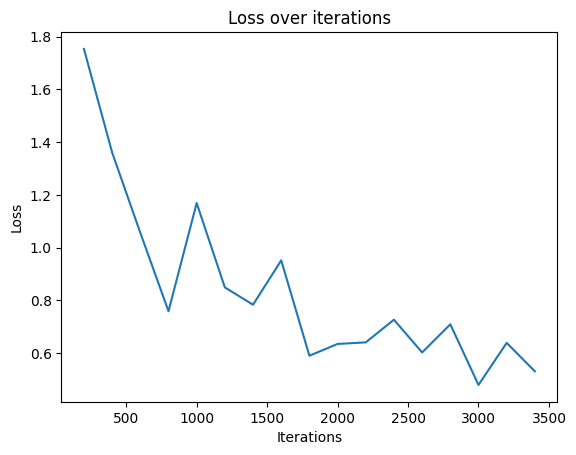

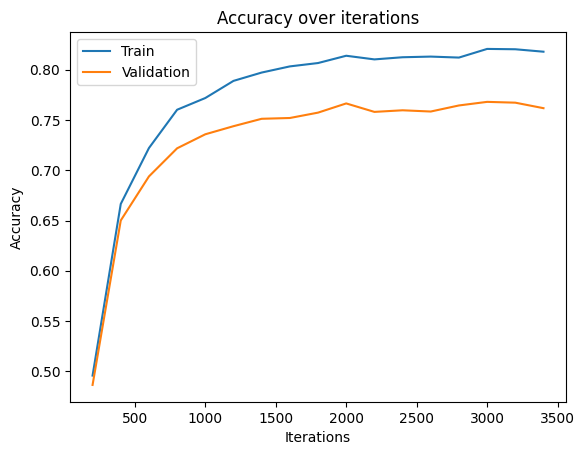

In [ ]:
cnn = CNN()
train_model(cnn, train_data_tensor, valid_data_tensor, batch_size=64, learning_rate=0.001, num_epochs=10, plot_every=200, weight_decay=0.001)

In [ ]:
torch.save(cnn.state_dict(), "drive/MyDrive/cnn_params.pth")

In [ ]:
! ls "/content/drive/My Drive" -l | grep "cnn_params"

ls: '/content/drive/My Drive/Praxis Teardown 1 & 2': No such file or directory
ls: '/content/drive/My Drive/Engineering Science': No such file or directory
ls: '/content/drive/My Drive/textbooks engsci year 1': No such file or directory
-rw------- 1 root root   2324002 Apr 15 16:32 cnn_params.pth


# Load Saved Data

In [5]:
import numpy as np

# Replace 'path_to_your_files' with the actual path to the folder containing your .npy files
train_data_path = '/content/drive/My Drive/train_data.npy'
train_targets_path = '/content/drive/My Drive/train_targets.npy'

# Load the data
train_data = np.load(train_data_path)
train_targets = np.load(train_targets_path)

test_data_path = '/content/drive/My Drive/test_data.npy'
test_targets_path = '/content/drive/My Drive/test_targets.npy'

# Load the data
test_data = np.load(test_data_path)
test_targets = np.load(test_targets_path)

In [6]:
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models, torchvision.datasets
import torchvision.transforms as transforms
warnings.filterwarnings('once')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

perm = np.random.permutation(train_data.shape[0])
train_data = train_data[perm]
train_targets = train_targets[perm]
train_data = train_data.reshape(-1, 1, 128, 33)
test_data = test_data.reshape(-1, 1, 128, 33)

valid_data = train_data[23000:, :, :]
valid_targets = train_targets[23000:, :]

train_data = train_data[:23000, :, :]
train_targets = train_targets[:23000, :]

# VGG16 Model

In [4]:
import torchvision.models as models

In [7]:
train_data_tensor = torch.utils.data.TensorDataset(torch.tensor(train_data).float().to(device), torch.tensor(train_targets).to(device))
valid_data_tensor = torch.utils.data.TensorDataset(torch.tensor(valid_data).float().to(device), torch.tensor(valid_targets).to(device))
test_data_tensor = torch.utils.data.TensorDataset(torch.tensor(test_data).float().to(device), torch.tensor(test_targets).to(device))

train_data_loader = torch.utils.data.DataLoader(train_data_tensor, batch_size=64, shuffle=True)
dbatch, tbatch = next(iter(train_data_loader))
print(dbatch.shape, tbatch.shape)

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


torch.Size([8, 1, 128, 33]) torch.Size([8, 27])


learning rate: 0.001, weight decay: 0.001
Iter 2000; Loss 3.266345; Train Acc 0.055; Val Acc 0.056
learning rate: 0.001, weight decay: 0.0001
Iter 2000; Loss 3.245483; Train Acc 0.055; Val Acc 0.056
learning rate: 0.001, weight decay: 0.0005
Iter 2000; Loss 3.304291; Train Acc 0.053; Val Acc 0.052
learning rate: 0.001, weight decay: 5e-05
Iter 2000; Loss 3.279247; Train Acc 0.053; Val Acc 0.052
learning rate: 0.001, weight decay: 1e-05
Iter 2000; Loss 3.261422; Train Acc 0.055; Val Acc 0.056
learning rate: 0.0001, weight decay: 0.001
Iter 2000; Loss 3.291917; Train Acc 0.053; Val Acc 0.052
learning rate: 0.0001, weight decay: 0.0001
Iter 2000; Loss 1.547594; Train Acc 0.518; Val Acc 0.512
learning rate: 0.0001, weight decay: 0.0005
Iter 2000; Loss 2.582151; Train Acc 0.265; Val Acc 0.263
learning rate: 0.0001, weight decay: 5e-05
Iter 2000; Loss 0.977623; Train Acc 0.769; Val Acc 0.740
learning rate: 0.0001, weight decay: 1e-05
Iter 2000; Loss 2.043515; Train Acc 0.412; Val Acc 0.391
l

<ipython-input-10-dc2fd0cbeaae>:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


learning rate: 0.0005, weight decay: 0.0001
Iter 2000; Loss 3.236147; Train Acc 0.055; Val Acc 0.056
learning rate: 0.0005, weight decay: 0.0005
Iter 2000; Loss 3.246481; Train Acc 0.055; Val Acc 0.056
learning rate: 0.0005, weight decay: 5e-05
Iter 2000; Loss 3.281891; Train Acc 0.055; Val Acc 0.056
learning rate: 0.0005, weight decay: 1e-05
Iter 2000; Loss 3.332416; Train Acc 0.055; Val Acc 0.056
learning rate: 5e-05, weight decay: 0.001
Iter 2000; Loss 1.437409; Train Acc 0.564; Val Acc 0.551
learning rate: 5e-05, weight decay: 0.0001
Iter 2000; Loss 1.256847; Train Acc 0.743; Val Acc 0.708
learning rate: 5e-05, weight decay: 0.0005
Iter 2000; Loss 1.173720; Train Acc 0.712; Val Acc 0.682
learning rate: 5e-05, weight decay: 5e-05
Iter 2000; Loss 1.212792; Train Acc 0.706; Val Acc 0.671
learning rate: 5e-05, weight decay: 1e-05
Iter 2000; Loss 0.973756; Train Acc 0.751; Val Acc 0.718
learning rate: 1e-05, weight decay: 0.001
Iter 2000; Loss 1.671178; Train Acc 0.431; Val Acc 0.410
le

KeyboardInterrupt: 

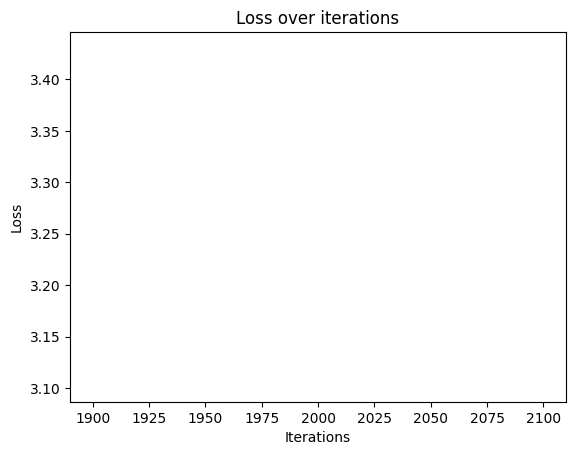

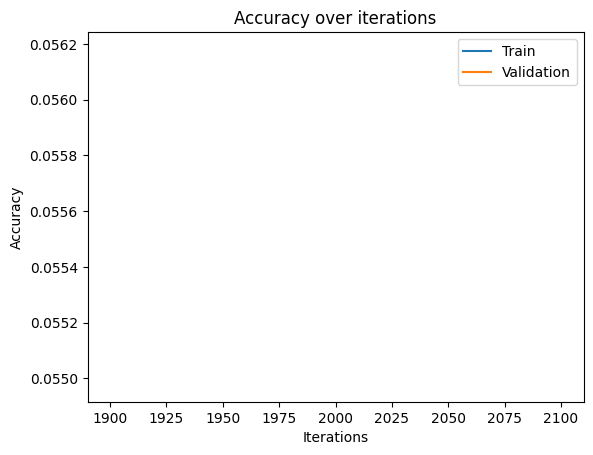

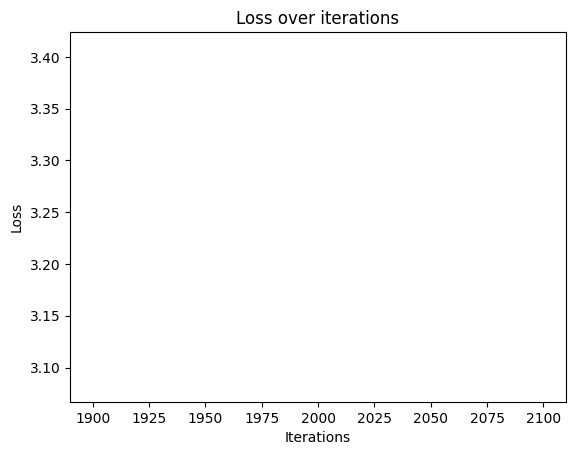

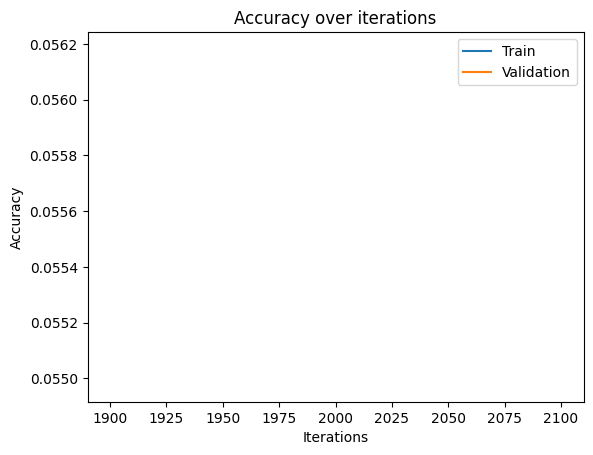

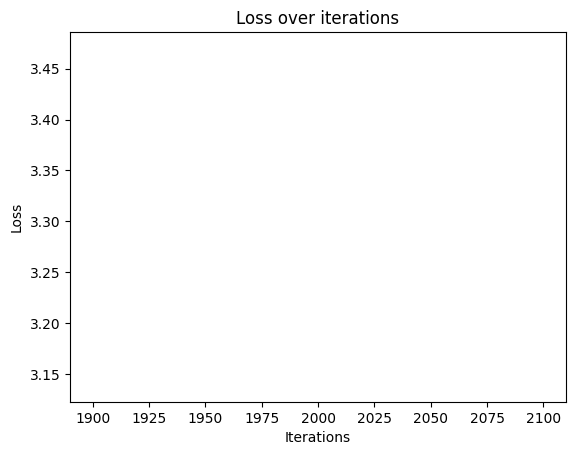

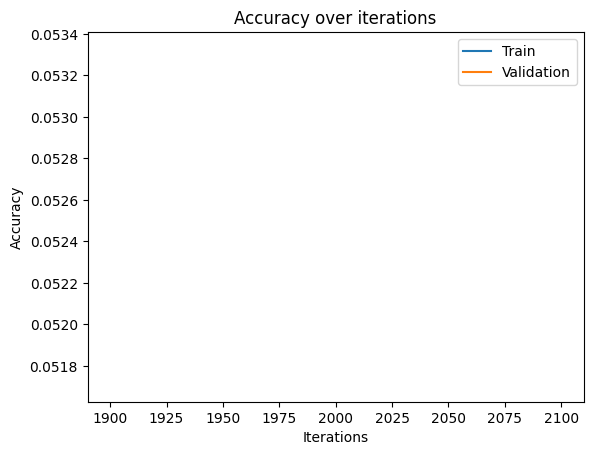

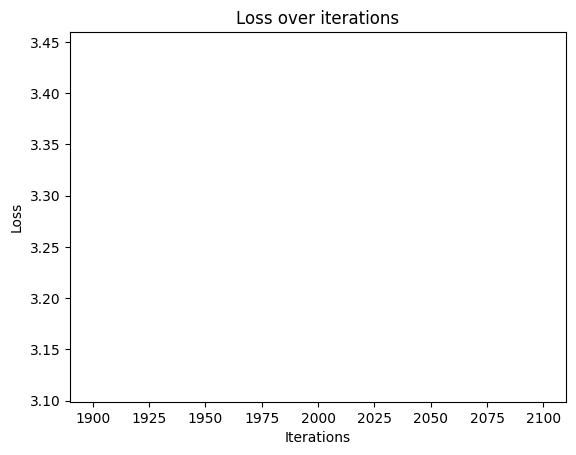

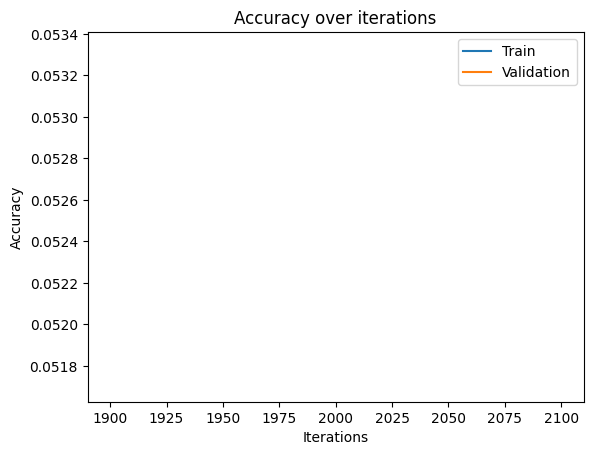

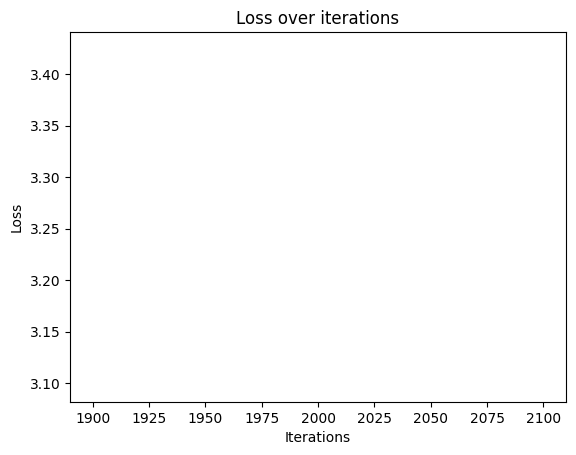

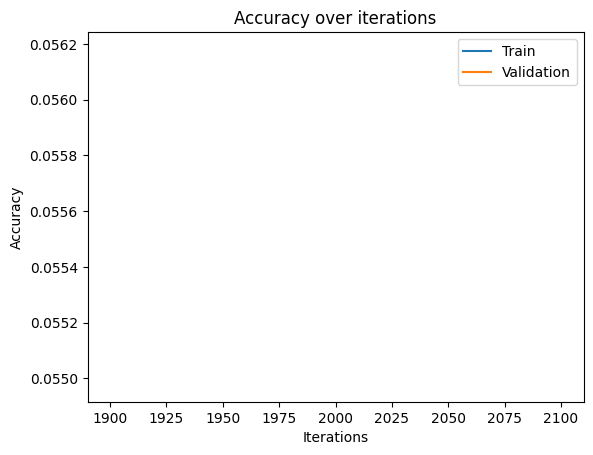

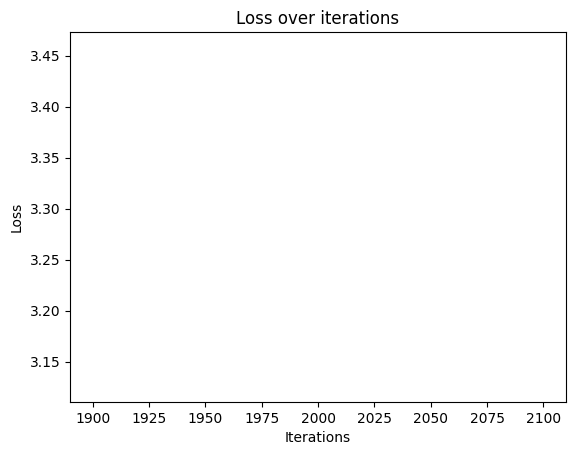

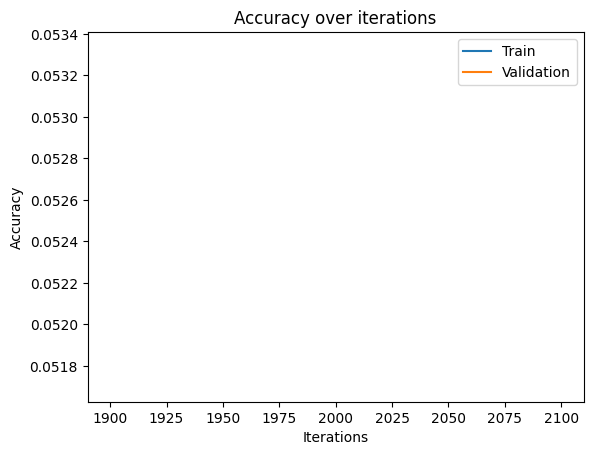

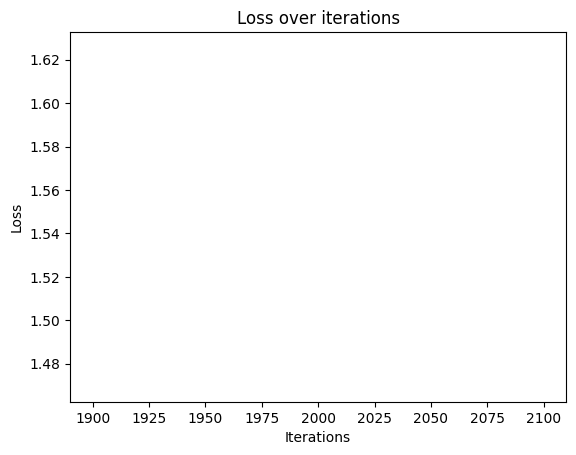

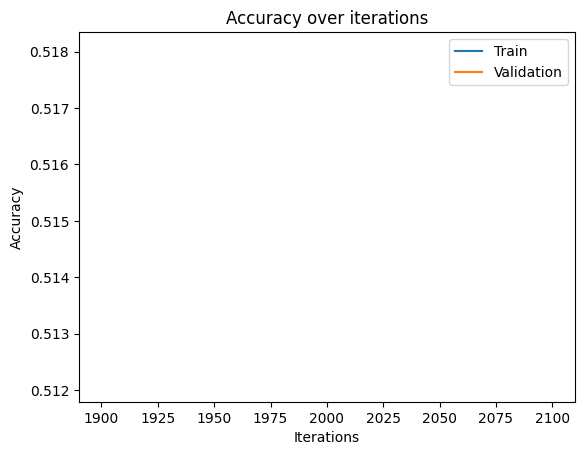

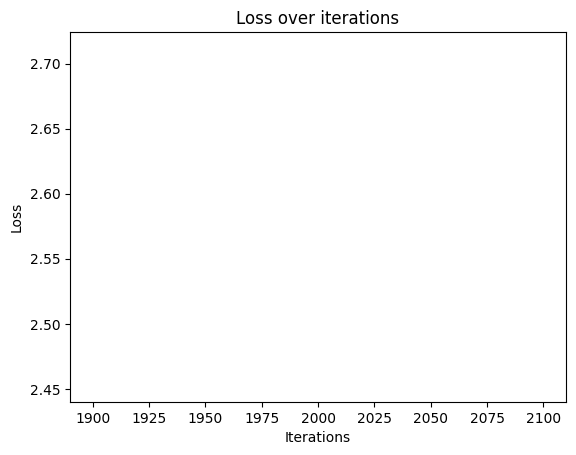

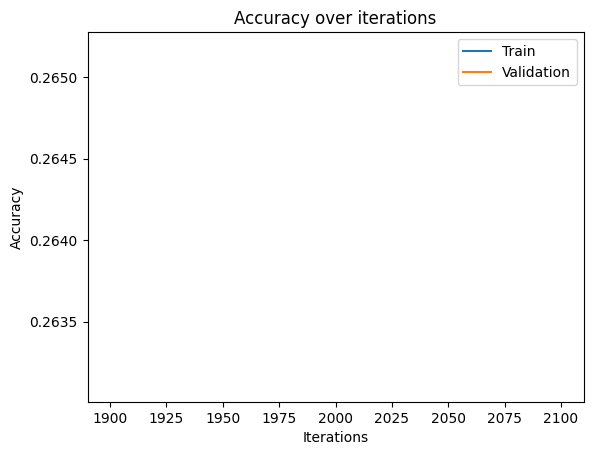

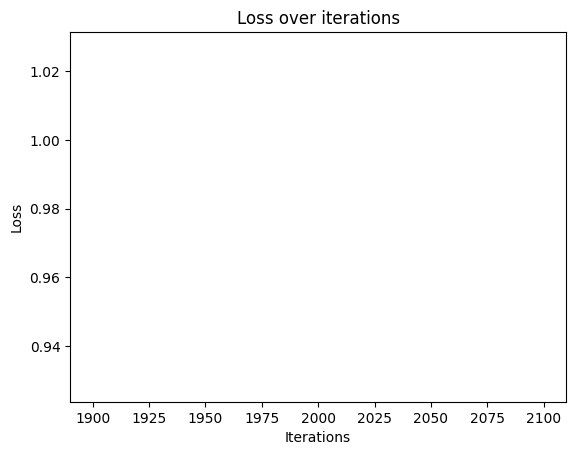

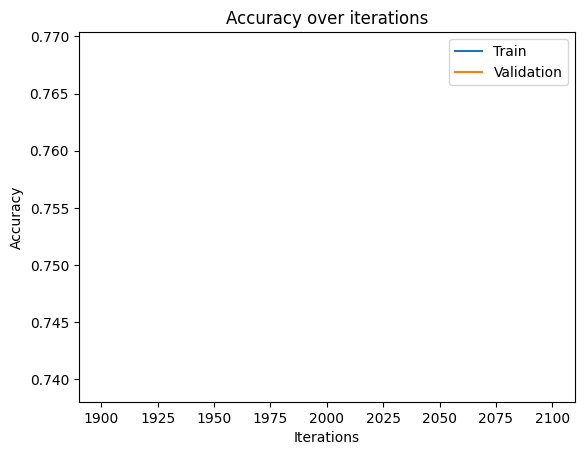

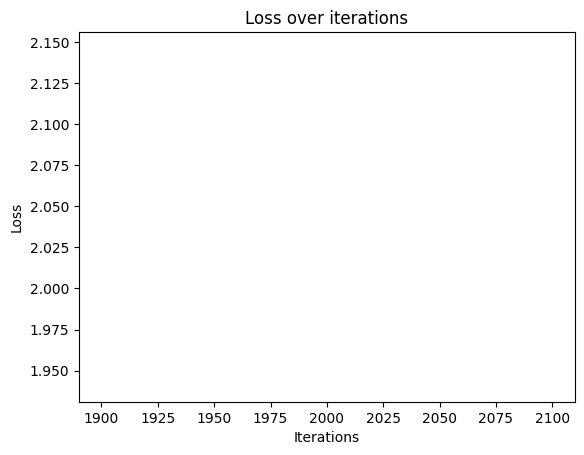

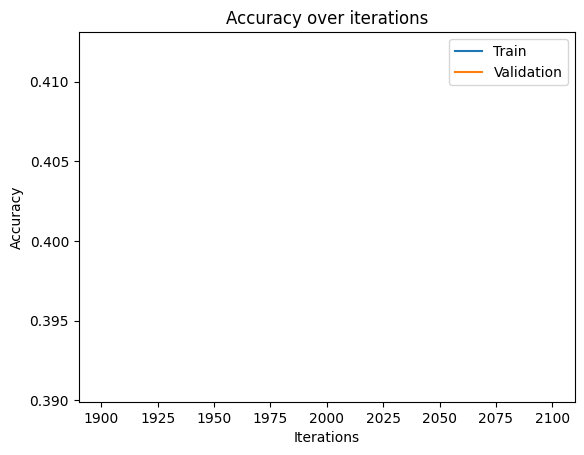

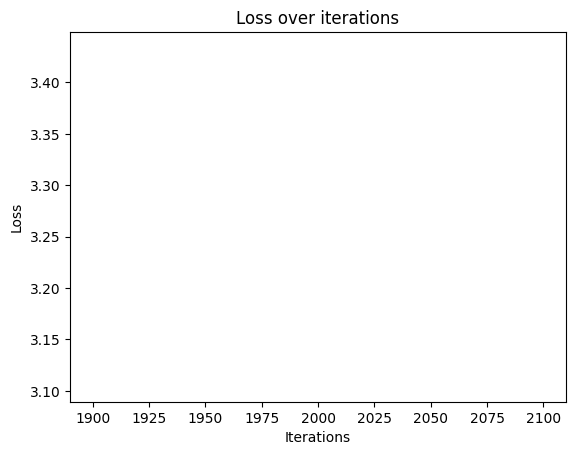

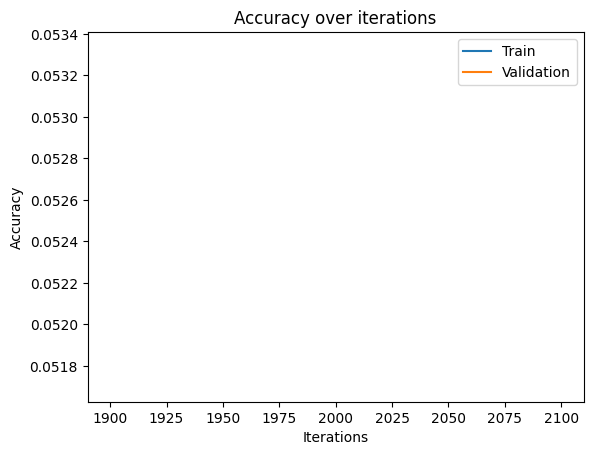

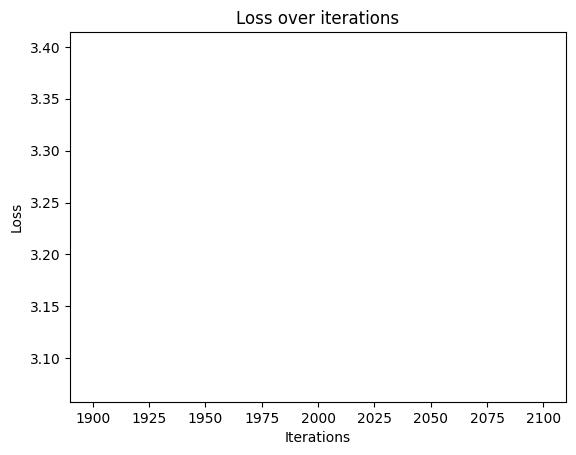

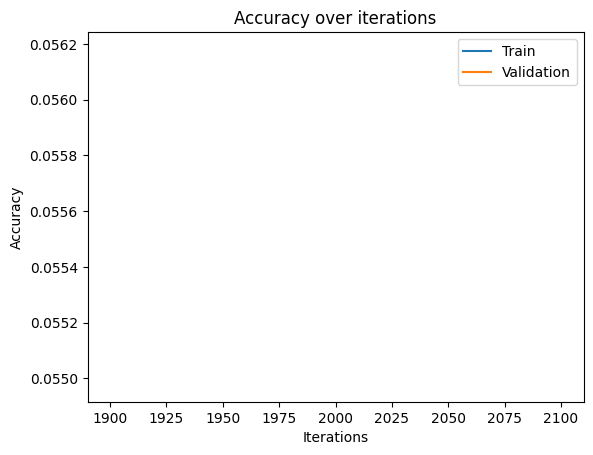

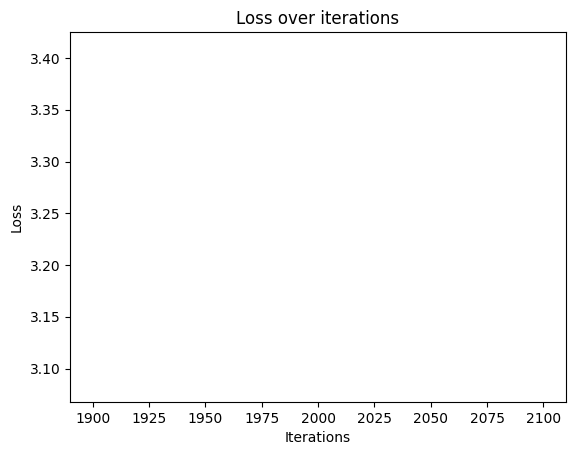

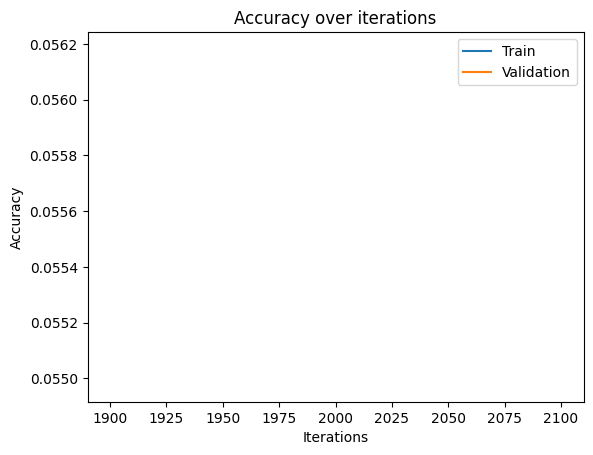

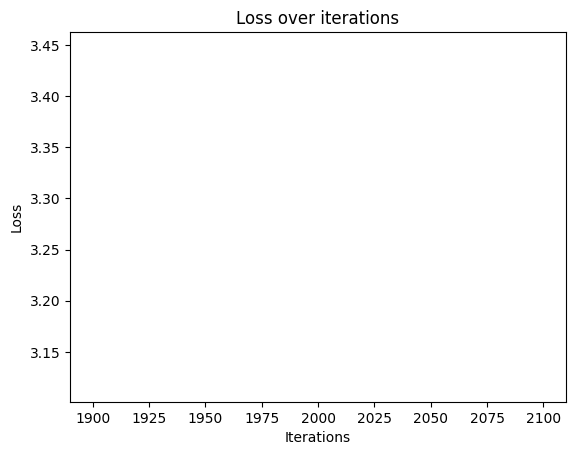

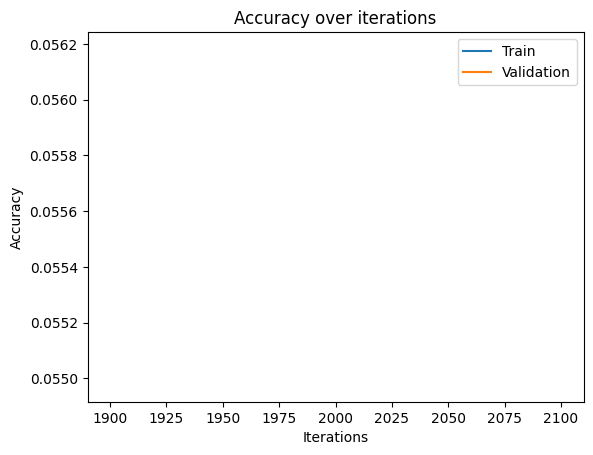

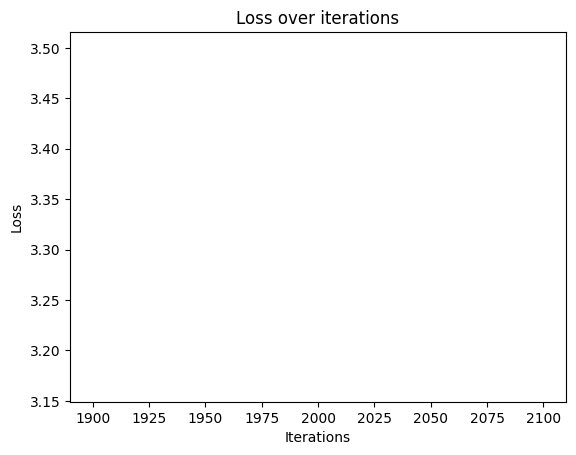

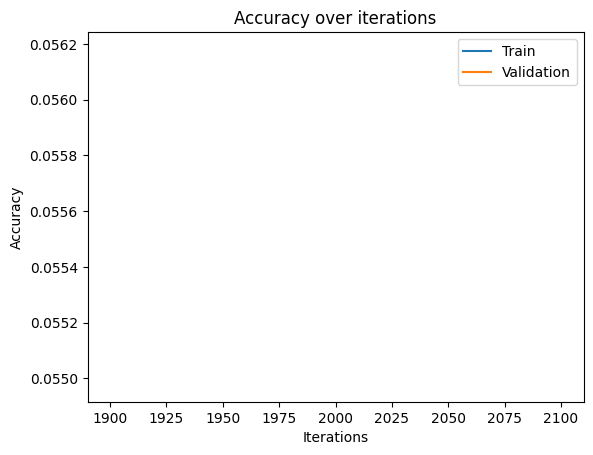

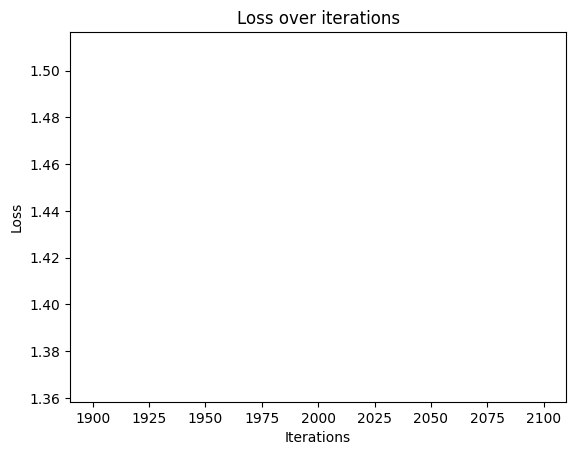

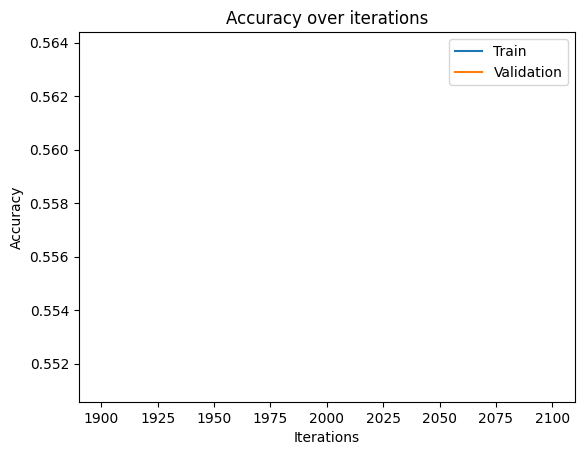

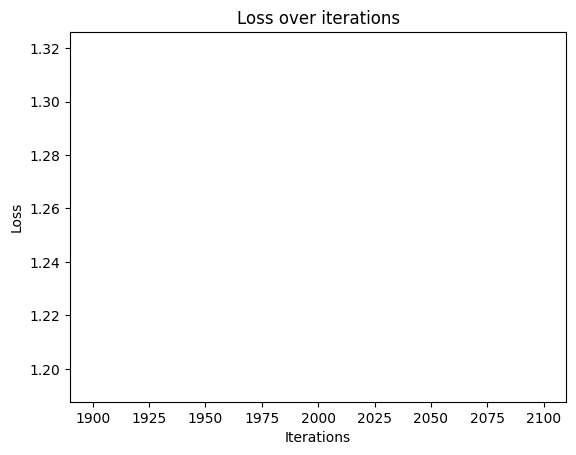

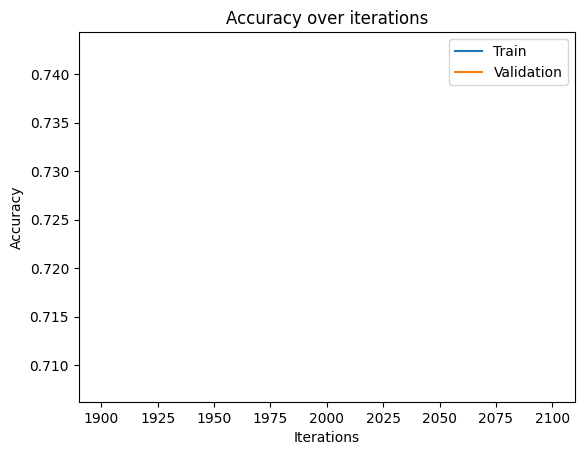

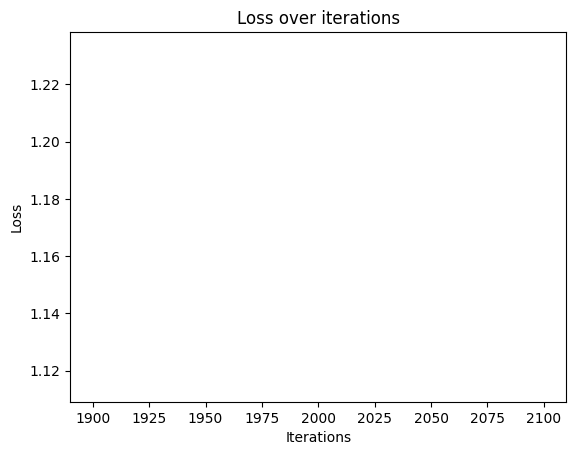

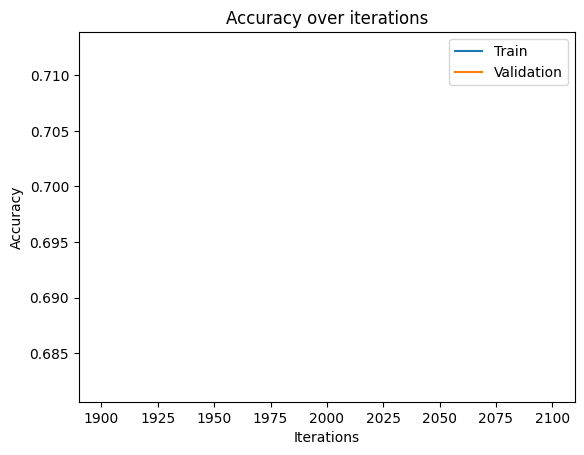

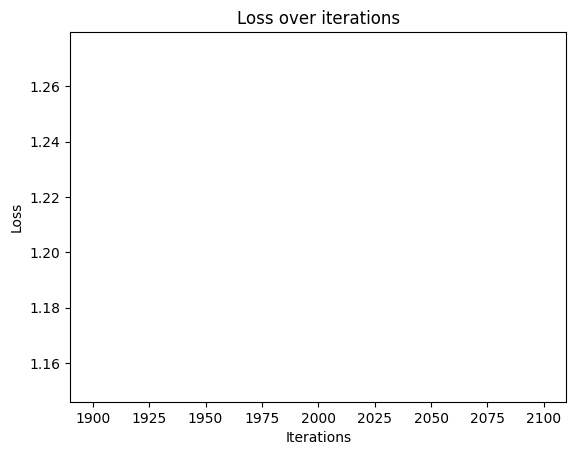

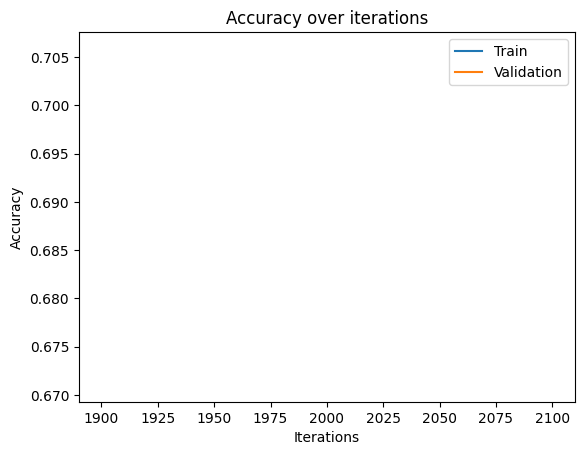

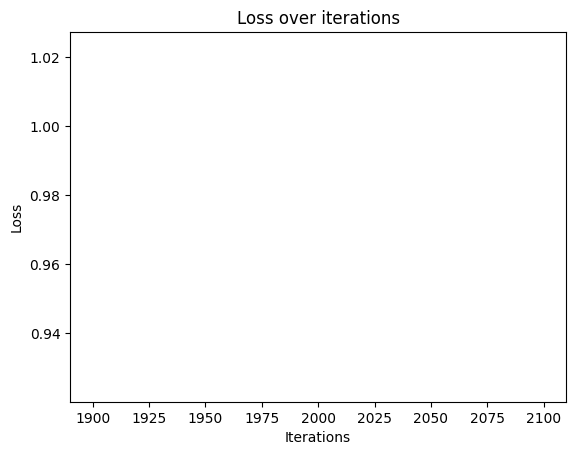

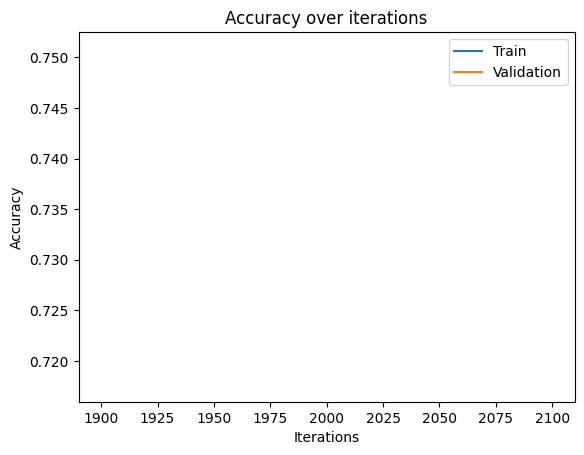

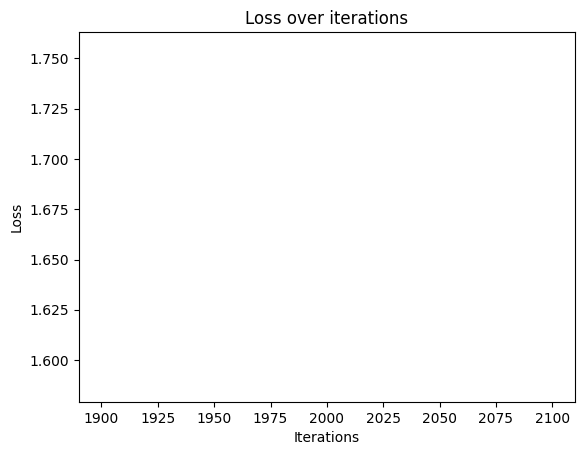

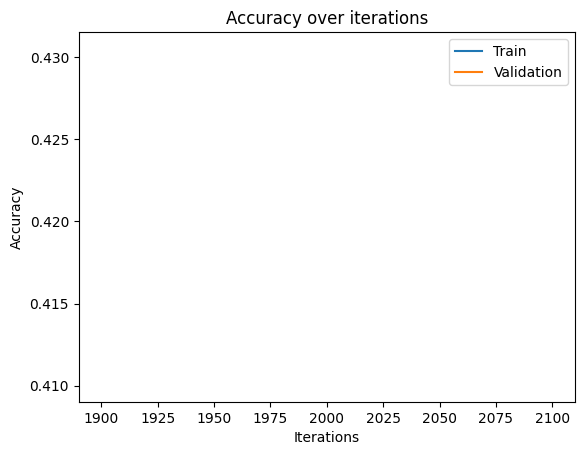

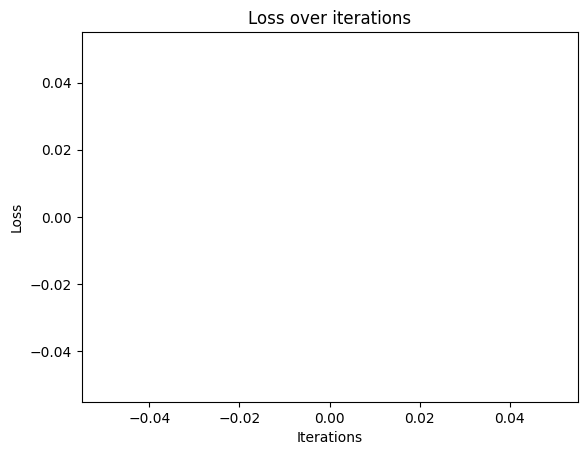

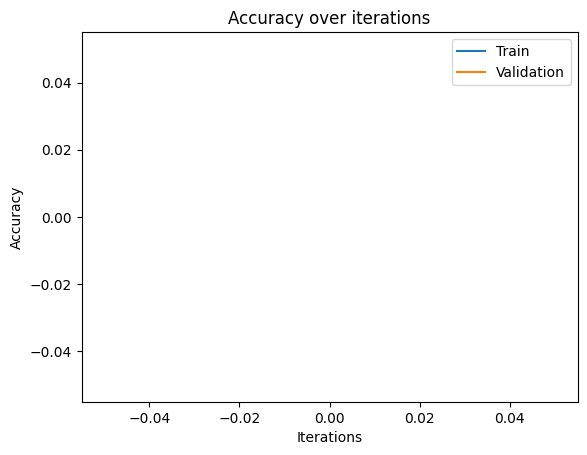

In [12]:
# Brief Grid Search for hyperparams
p = [0.001, 0.0001, 0.0005, 0.00005, 0.00001]
for i in range(5):
  for j in range(5):
    num_classes = 27

    # Load pre-trained VGG16 model
    vgg16 = models.vgg16(pretrained=True).to(torch.float)

    # Modify the first convolutional layer to accept 1 channel input
    vgg16.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

    # Modify the classifier to output 27 classes
    vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, 27)

    vgg16.to(device)
    print(f"learning rate: {p[i]}, weight decay: {p[j]}")
    train_model(vgg16, train_data_tensor, valid_data_tensor, batch_size=64, learning_rate=p[i], num_epochs=6, plot_every=2000, weight_decay=p[j], plot=False)

Iter 200; Loss 3.058345; Train Acc 0.113; Val Acc 0.111
Iter 400; Loss 2.636597; Train Acc 0.257; Val Acc 0.251
Iter 600; Loss 2.199753; Train Acc 0.429; Val Acc 0.417
Iter 800; Loss 1.636132; Train Acc 0.534; Val Acc 0.523
Iter 1000; Loss 1.614849; Train Acc 0.609; Val Acc 0.596
Iter 1200; Loss 1.293680; Train Acc 0.653; Val Acc 0.624
Iter 1400; Loss 0.989630; Train Acc 0.709; Val Acc 0.681
Iter 1600; Loss 0.973252; Train Acc 0.745; Val Acc 0.709
Iter 1800; Loss 0.994550; Train Acc 0.730; Val Acc 0.692
Iter 2000; Loss 0.775600; Train Acc 0.782; Val Acc 0.746
Iter 2200; Loss 1.063493; Train Acc 0.780; Val Acc 0.741
Iter 2400; Loss 1.072528; Train Acc 0.813; Val Acc 0.774
Iter 2600; Loss 0.623079; Train Acc 0.822; Val Acc 0.783
Iter 2800; Loss 0.897228; Train Acc 0.830; Val Acc 0.788
Iter 3000; Loss 1.050308; Train Acc 0.833; Val Acc 0.787
Iter 3200; Loss 0.778036; Train Acc 0.844; Val Acc 0.801
Iter 3400; Loss 0.780449; Train Acc 0.840; Val Acc 0.796
Iter 3600; Loss 0.623646; Train Acc

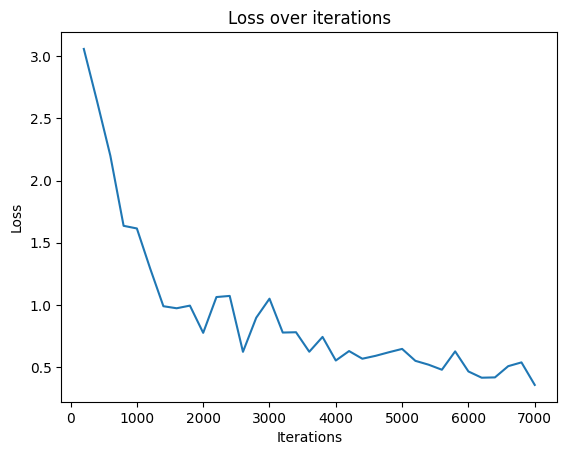

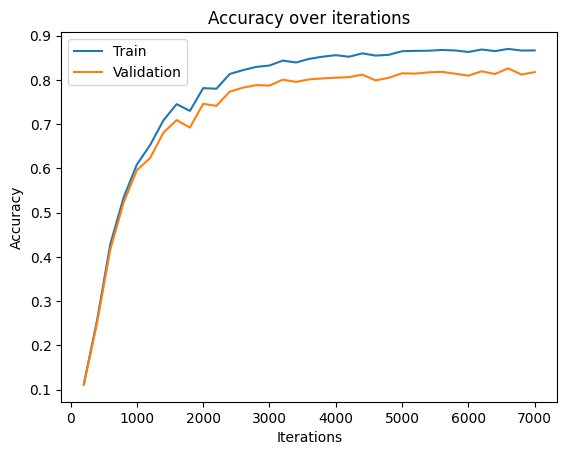

In [16]:
num_classes = 27

# Load pre-trained VGG16 model
vgg16 = models.vgg16(pretrained=True).to(torch.float)

# Modify the first convolutional layer to accept 1 channel input
vgg16.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

# Optionally add an adaptive pooling layer to resize feature maps
#vgg16.features = nn.Sequential(
    #nn.AdaptiveAvgPool2d((128, 33)),
    #vgg16.features,
#)

# Modify the classifier to output 27 classes
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, 27)

vgg16.to(device)
train_model(vgg16, train_data_tensor, valid_data_tensor, batch_size=64, learning_rate=5e-05, weight_decay=1e-05, num_epochs=20, plot_every=200)

In [17]:
torch.save(vgg16.state_dict(), "drive/MyDrive/vgg16_params.pth")

# VGG16 Performance Analysis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Confusion Matrix (Test Data)')

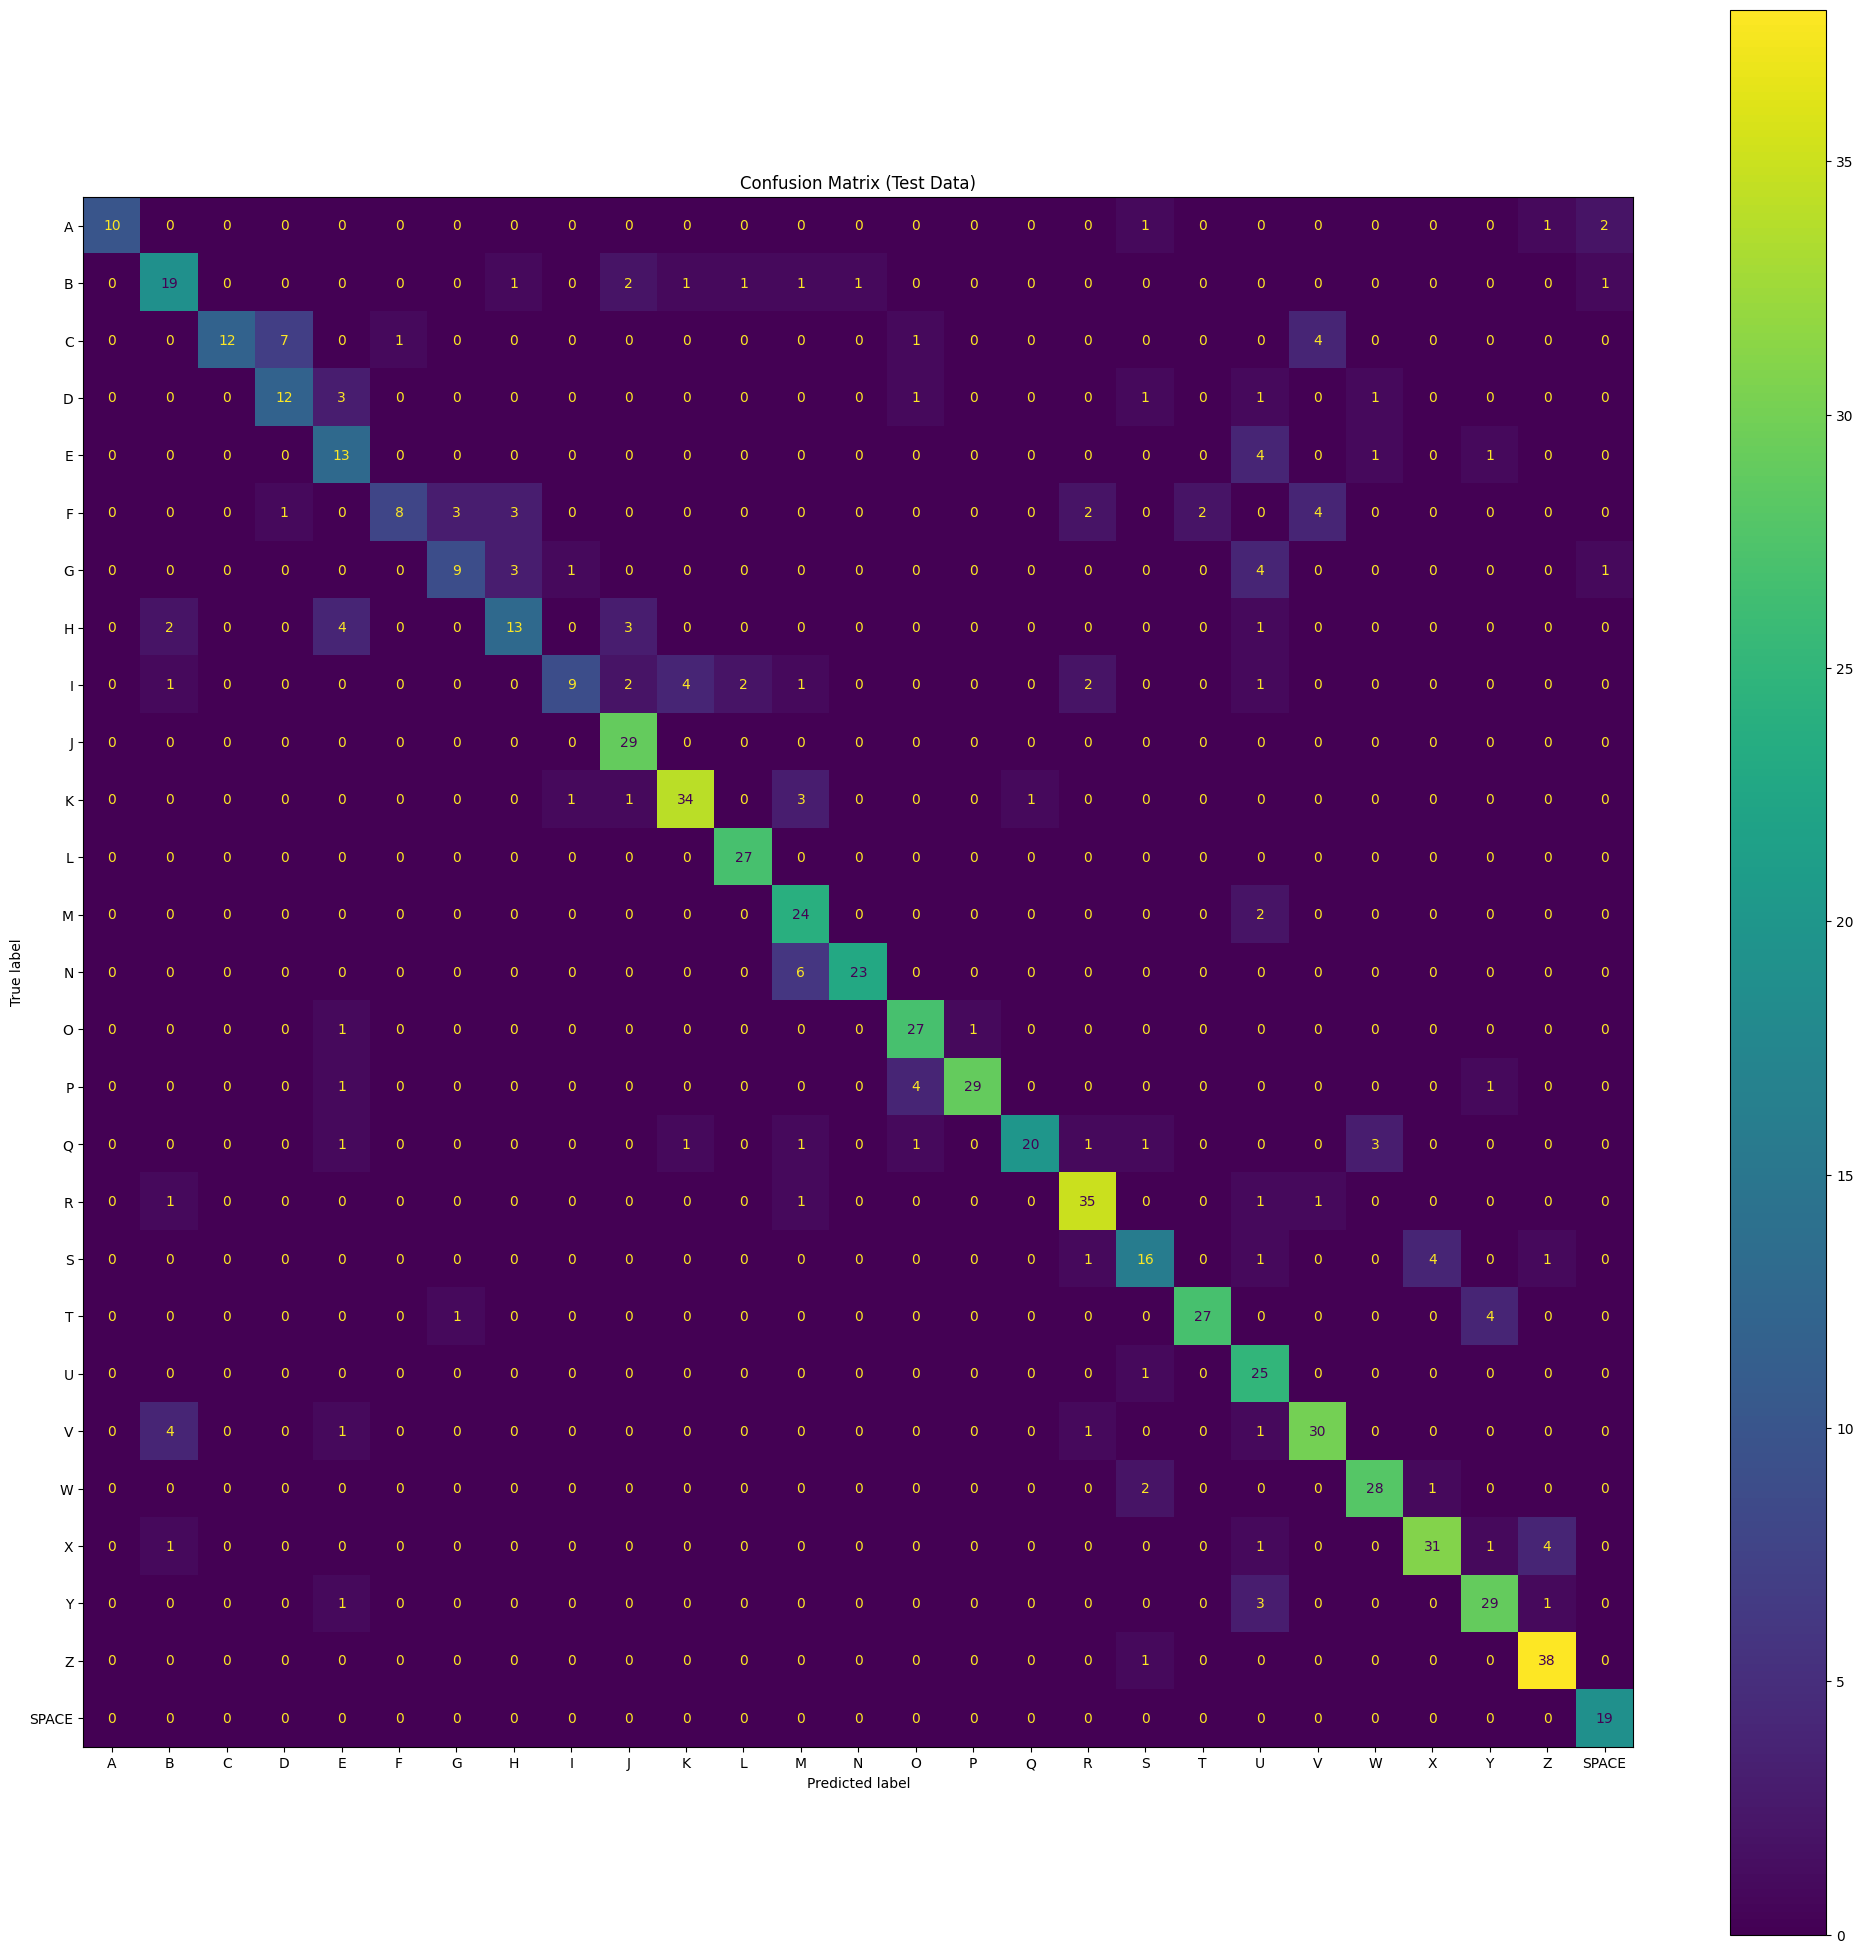

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def get_prediction(model, data, sample=1000):
    loader = torch.utils.data.DataLoader(data, batch_size=sample, shuffle=True)
    for X, t in loader:
        z = model(X)
        y = torch.sigmoid(z)
        break
    return y, t

fig, ax = plt.subplots(figsize=(25, 25))
ax.set(
    xticks=np.arange(27),
    yticks=np.arange(27)
)
y, t = get_prediction(vgg16, test_data_tensor, sample=5000)
y = torch.argmax(y, axis=1)
t = torch.argmax(t, axis=1)
y = y.to('cpu').numpy()
t = t.to('cpu').numpy()
cm = confusion_matrix(t, y)
cmp = ConfusionMatrixDisplay(cm, display_labels=list("ABCDEFGHIJKLMNOPQRSTUVWXYZ") + ["SPACE"])
cmp.plot(ax=ax)
ax.set_title("Confusion Matrix (Test Data)")

Test accuracy of VGG16: 0.7925531914893617


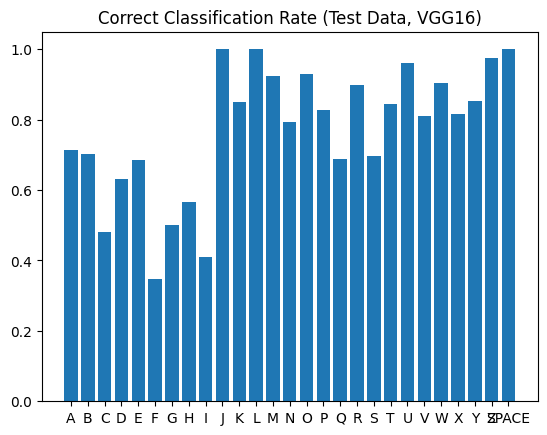

In [20]:
classification_rate = cm.diagonal() / cm.sum(axis=1)
plt.bar(list("ABCDEFGHIJKLMNOPQRSTUVWXYZ") + ['SPACE'], classification_rate)
plt.title("Correct Classification Rate (Test Data, VGG16)")

print(f"Test accuracy of VGG16: {np.sum(cm.diagonal()) / test_data.shape[0]}")

In [22]:
import sklearn.metrics
print(f"The F1 score of the VGG16: {sklearn.metrics.f1_score(t, y, average='weighted')}")
print(f"The recall score of the VGG16: {sklearn.metrics.recall_score(t, y, average='weighted')}")
print(f"The precision score of the VGG16: {sklearn.metrics.precision_score(t, y, average='weighted')}")

y_auc, t_auc = get_prediction(vgg16, test_data_tensor)
y_auc = y_auc.to('cpu').detach().numpy()
t_auc = t_auc.to('cpu').detach().numpy()
print(f"The AUC score of the VGG16: {sklearn.metrics.roc_auc_score(t_auc, y_auc, multi_class='ovo')}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The F1 score of the VGG16: 0.7869801281758237
The recall score of the VGG16: 0.7925531914893617
The precision score of the VGG16: 0.8123240408662314
The AUC score of the VGG16: 0.9793583719460246


# CoatNet Model Attempt

In [ ]:
train_data_tensor = torch.utils.data.TensorDataset(torch.tensor(train_data).float().to(device), torch.tensor(train_targets).to(device))
valid_data_tensor = torch.utils.data.TensorDataset(torch.tensor(valid_data).float().to(device), torch.tensor(valid_targets).to(device))
test_data_tensor = torch.utils.data.TensorDataset(torch.tensor(test_data).float().to(device), torch.tensor(test_targets).to(device))

train_data_loader = torch.utils.data.DataLoader(train_data_tensor, batch_size=8, shuffle=True)
dbatch, tbatch = next(iter(train_data_loader))
print(dbatch.shape, tbatch.shape)

In [8]:
class ConvEmbed(nn.Module):
    """Convolution block with ReLU activation and Batch Normalization."""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.proj = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        return self.proj(x)

class TransformerBlock(nn.Module):
    """Transformer block with Layer Normalization, Multi-head Self-attention, and an MLP."""
    def __init__(self, dim, heads=4, dim_head=16, mlp_dim=64, dropout=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=heads, dropout=dropout)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        # Transform input to (seq_len, batch, embedding_dim) for nn.MultiheadAttention
        x = x.permute(1, 0, 2)  # From (B, N, C) to (N, B, C)
        x = self.norm1(x)
        x, _ = self.attn(x, x, x)
        x = x.permute(1, 0, 2)  # Back to (B, N, C)
        x = self.norm2(x)
        x = self.mlp(x) + x
        return x

class CoAtNet(nn.Module):
    """CoAtNet-like model."""
    def __init__(self, in_channels, num_classes, flattened_dim):
        super().__init__()
        self.initial_conv = ConvEmbed(in_channels, 32, kernel_size=7, stride=2, padding=3)
        # Manually specify the flattened dimension for the transformer block
        self.transformer_block1 = TransformerBlock(dim=flattened_dim, heads=4, dim_head=16, mlp_dim=64)

        # Will be initialized properly in the first forward pass
        self.transformer_block1 = None
        self.conv1 = ConvEmbed(32, 64, 3, 2)
        self.adapt_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.initial_conv(x)
        b, c, h, w = x.shape  # Extract the feature dimensions

        if self.transformer_block1 is None:
            # Compute the flattened dimension dynamically and initialize transformer_block1
            flattened_dim = c * h * w
            self.transformer_block1 = TransformerBlock(dim=flattened_dim, heads=8, dim_head=32, mlp_dim=2048)

        x = x.view(b, c * h * w)  # Flatten spatial dimensions for Transformer input
        x = self.transformer_block1(x)

        # Before passing to conv1, reshape x back to feature map style
        x = x.view(b, c, h, w)
        x = self.conv1(x)
        x = self.adapt_pool(x)
        x = x.view(x.shape[0], -1)  # Flatten for the classifier
        x = self.classifier(x)
        return x

In [ ]:
# Assuming the input size is (1, 128, 33)
in_channels = 1
height = 128
width = 33
# Calculate the output size after the initial convolution
conv_out_channels = 32
conv_out_height = height // 2  # due to stride=2
conv_out_width = width // 2  # due to stride=2

# Calculate the flattened dimension
flattened_dim = conv_out_channels * conv_out_height * conv_out_width

# Initialize the CoAtNet model with the flattened dimension
coatnet = CoAtNet(in_channels=in_channels, num_classes=127, flattened_dim=flattened_dim)

In [10]:
import torch.nn.functional as F

In [ ]:
coatnet.to(device)
train_model(coatnet, train_data_tensor, valid_data_tensor, batch_size=8, learning_rate=5e-05, weight_decay=1e-05, num_epochs=20, plot_every=200)

# VGG16 Test Runs

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Iter 100; Loss 3.270333; Train Acc 0.059; Val Acc 0.060
Iter 200; Loss 3.214423; Train Acc 0.068; Val Acc 0.068
Iter 300; Loss 3.284925; Train Acc 0.053; Val Acc 0.052
Iter 400; Loss 3.286779; Train Acc 0.055; Val Acc 0.055
Iter 500; Loss 3.244961; Train Acc 0.055; Val Acc 0.056
Iter 600; Loss 3.288277; Train Acc 0.055; Val Acc 0.056
Iter 700; Loss 3.291251; Train Acc 0.067; Val Acc 0.066
Iter 800; Loss 3.250680; Train Acc 0.053; Val Acc 0.052
Iter 900; Loss 3.276430; Train Acc 0.055; Val Acc 0.056
Iter 1000; Loss 3.261731; Train Acc 0.055; Val Acc 0.056
Iter 1100; Loss 3.254171; Train Acc 0.053; Val Acc 0.052
Iter 1200; Loss 3.192916; Train Acc 0.085; Val Acc 0.080
Iter 1300; Loss 3.059874; Train Acc 0.107; Val Acc 0.106
Iter 1400; Loss 2.928040; Train Acc 0.136; Val Acc 0.137
Iter 1500; Loss 2.705853; Train Acc 0.171; Val Acc 0.164
Iter 1600; Loss 2.720433; Train Acc 0.224; Val Acc 0.219
Iter 1700; Loss 2.294606; Train Acc 0.267; Val Acc 0.254
Iter 1800; Loss 2.344901; Train Acc 0.27

KeyboardInterrupt: 

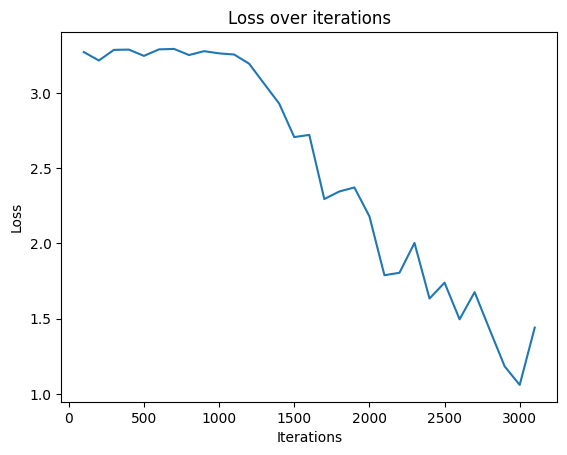

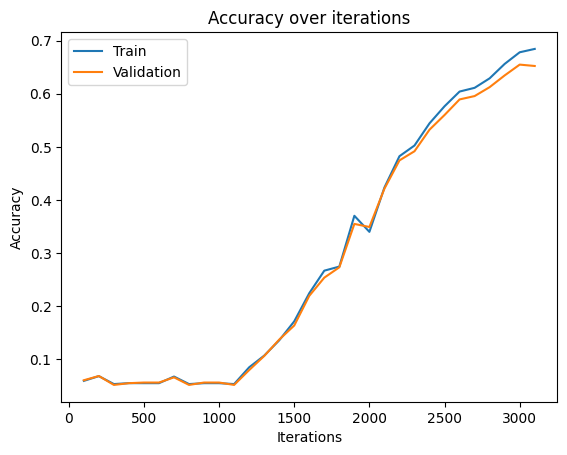

In [13]:
num_classes = 27

# Load pre-trained VGG16 model
vgg16 = models.vgg16(pretrained=True).to(torch.float)

# Modify the first convolutional layer to accept 1 channel input
vgg16.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

# Optionally add an adaptive pooling layer to resize feature maps
#vgg16.features = nn.Sequential(
    #nn.AdaptiveAvgPool2d((128, 33)),
    #vgg16.features,
#)

# Modify the classifier to output 27 classes
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, 27)

vgg16.to(device)
train_model(vgg16, train_data_tensor, valid_data_tensor, batch_size=64, learning_rate=0.0001, weight_decay=5e-05, num_epochs=10, plot_every=100)

In [ ]:
torch.save(vgg16.state_dict(), "drive/MyDrive/vgg16_params.pth")

Iter 100; Loss 3.266212; Train Acc 0.068; Val Acc 0.072
Iter 200; Loss 3.275220; Train Acc 0.054; Val Acc 0.053
Iter 300; Loss 3.238101; Train Acc 0.060; Val Acc 0.061
Iter 400; Loss 3.278571; Train Acc 0.056; Val Acc 0.054
Iter 500; Loss 3.245538; Train Acc 0.048; Val Acc 0.044
Iter 600; Loss 3.265842; Train Acc 0.053; Val Acc 0.052
Iter 700; Loss 3.277454; Train Acc 0.056; Val Acc 0.054
Iter 800; Loss 3.237672; Train Acc 0.056; Val Acc 0.051
Iter 900; Loss 3.256071; Train Acc 0.050; Val Acc 0.049
Iter 1000; Loss 3.219223; Train Acc 0.062; Val Acc 0.067
Iter 1100; Loss 3.118303; Train Acc 0.077; Val Acc 0.068
Iter 1200; Loss 2.882952; Train Acc 0.132; Val Acc 0.134
Iter 1300; Loss 2.895813; Train Acc 0.143; Val Acc 0.141
Iter 1400; Loss 2.760961; Train Acc 0.180; Val Acc 0.177
Iter 1500; Loss 2.669042; Train Acc 0.203; Val Acc 0.201
Iter 1600; Loss 2.485487; Train Acc 0.277; Val Acc 0.272
Iter 1700; Loss 2.214129; Train Acc 0.319; Val Acc 0.326
Iter 1800; Loss 2.062201; Train Acc 0.38

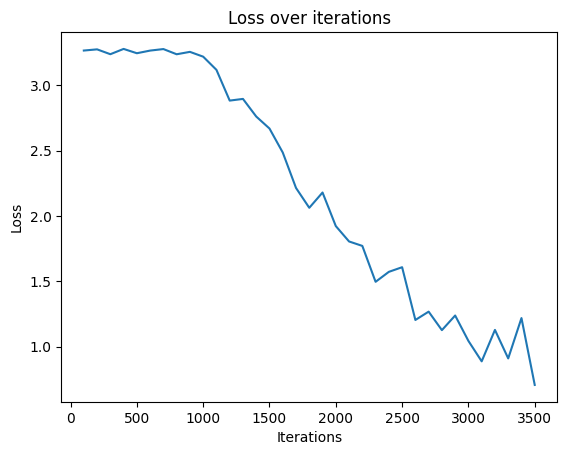

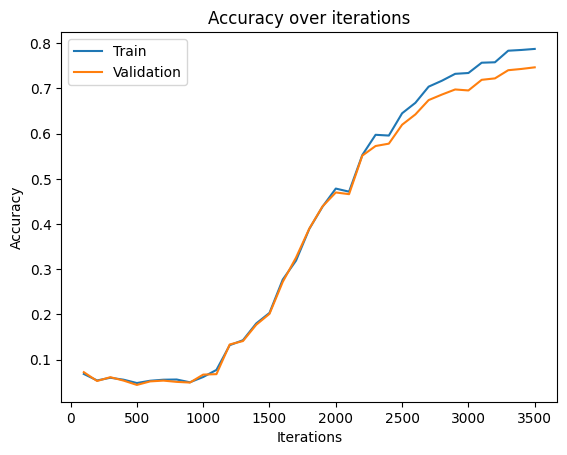

In [ ]:
# TODO: Need to do the following:
# 1. Resize the input data so that it works with VGG
# 2. Compute VGG features, then classify using our own MLP (we only have 27 classes)
# 3. Train and finetune the weights (will take a lot of training bc these images are very
#    different from the ImageNet data set)

num_classes = 27

# Load pre-trained VGG16 model
vgg16 = models.vgg16(pretrained=True).to(torch.float)

# Modify the first convolutional layer to accept 1 channel input
vgg16.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

# Optionally add an adaptive pooling layer to resize feature maps
#vgg16.features = nn.Sequential(
    #nn.AdaptiveAvgPool2d((128, 33)),
    #vgg16.features,
#)

# Modify the classifier to output 27 classes
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, 27)

vgg16.to(device)
train_model(vgg16, train_data_tensor, valid_data_tensor, batch_size=64, learning_rate=0.0001, num_epochs=10, plot_every=100)

Iter 200; Loss 3.247927; Train Acc 0.054; Val Acc 0.052
Iter 400; Loss 3.279047; Train Acc 0.048; Val Acc 0.050
Iter 600; Loss 3.260069; Train Acc 0.056; Val Acc 0.054
Iter 800; Loss 3.243780; Train Acc 0.066; Val Acc 0.066
Iter 1000; Loss 2.860087; Train Acc 0.143; Val Acc 0.147
Iter 1200; Loss 2.706496; Train Acc 0.216; Val Acc 0.211
Iter 1400; Loss 2.411386; Train Acc 0.320; Val Acc 0.315
Iter 1600; Loss 2.083745; Train Acc 0.430; Val Acc 0.436
Iter 1800; Loss 1.849025; Train Acc 0.484; Val Acc 0.476
Iter 2000; Loss 1.479669; Train Acc 0.570; Val Acc 0.553
Iter 2200; Loss 1.334212; Train Acc 0.616; Val Acc 0.602
Iter 2400; Loss 1.355902; Train Acc 0.652; Val Acc 0.624
Iter 2600; Loss 1.296750; Train Acc 0.674; Val Acc 0.655
Iter 2800; Loss 1.134294; Train Acc 0.721; Val Acc 0.689
Iter 3000; Loss 0.856062; Train Acc 0.731; Val Acc 0.702
Iter 3200; Loss 1.247767; Train Acc 0.761; Val Acc 0.724
Iter 3400; Loss 1.046891; Train Acc 0.778; Val Acc 0.740
Iter 3600; Loss 0.911787; Train Acc

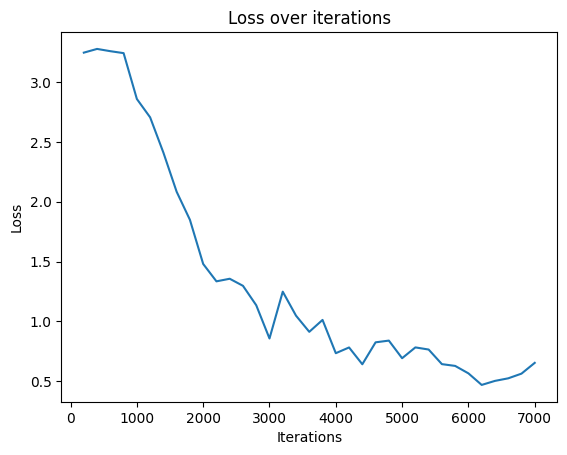

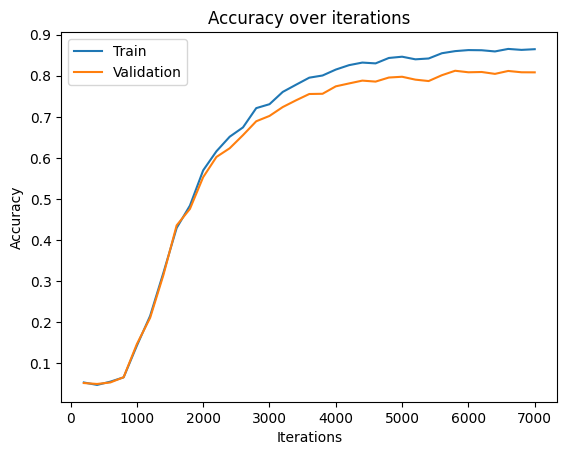

In [ ]:
num_classes = 27

# Load pre-trained VGG16 model
vgg16 = models.vgg16(pretrained=True).to(torch.float)

# Modify the first convolutional layer to accept 1 channel input
vgg16.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

# Optionally add an adaptive pooling layer to resize feature maps
#vgg16.features = nn.Sequential(
    #nn.AdaptiveAvgPool2d((128, 33)),
    #vgg16.features,
#)

# Modify the classifier to output 27 classes
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, 27)

vgg16.to(device)
train_model(vgg16, train_data_tensor, valid_data_tensor, batch_size=64, learning_rate=0.0001, num_epochs=20, plot_every=200)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Iter 200; Loss 3.277096; Train Acc 0.053; Val Acc 0.052
Iter 400; Loss 3.294052; Train Acc 0.056; Val Acc 0.054
Iter 600; Loss 3.275038; Train Acc 0.053; Val Acc 0.052
Iter 800; Loss 3.198298; Train Acc 0.063; Val Acc 0.061
Iter 1000; Loss 2.728488; Train Acc 0.158; Val Acc 0.159
Iter 1200; Loss 2.700338; Train Acc 0.241; Val Acc 0.244
Iter 1400; Loss 2.445033; Train Acc 0.330; Val Acc 0.327
Iter 1600; Loss 1.933445; Train Acc 0.447; Val Acc 0.441
Iter 1800; Loss 1.827872; Train Acc 0.462; Val Acc 0.458
Iter 2000; Loss 1.664937; Train Acc 0.584; Val Acc 0.569
Iter 2200; Loss 1.243504; Train Acc 0.613; Val Acc 0.594
Iter 2400; Loss 1.521978; Train Acc 0.661; Val Acc 0.642
Iter 2600; Loss 1.300256; Train Acc 0.701; Val Acc 0.667
Iter 2800; Loss 1.314371; Train Acc 0.722; Val Acc 0.691
Iter 3000; Loss 0.953513; Train Acc 0.753; Val Acc 0.718
Iter 3200; Loss 0.981803; Train Acc 0.777; Val Acc 0.743
Iter 3400; Loss 0.825857; Train Acc 0.779; Val Acc 0.746
Iter 3600; Loss 0.790110; Train Acc

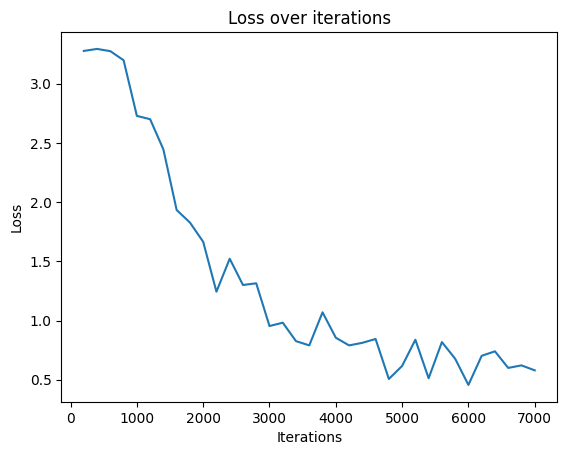

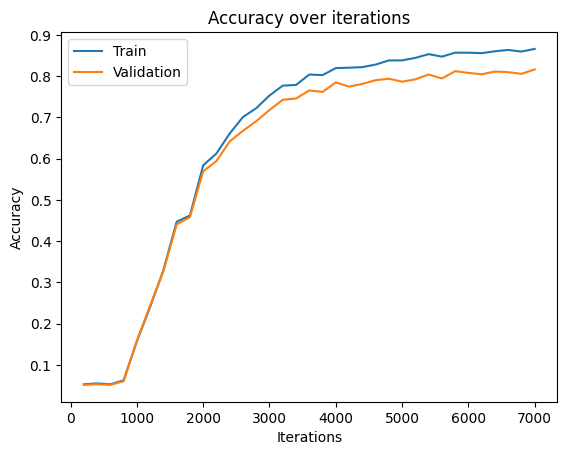

In [ ]:
num_classes = 27

# Load pre-trained VGG16 model
vgg16 = models.vgg16(pretrained=True).to(torch.float)

# Modify the first convolutional layer to accept 1 channel input
vgg16.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

# Optionally add an adaptive pooling layer to resize feature maps
#vgg16.features = nn.Sequential(
    #nn.AdaptiveAvgPool2d((128, 33)),
    #vgg16.features,
#)

# Modify the classifier to output 27 classes
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, 27)

vgg16.to(device)
train_model(vgg16, train_data_tensor, valid_data_tensor, batch_size=64, learning_rate=0.0001, weight_decay = 0.00001, num_epochs=20, plot_every=200)

Iter 200; Loss 3.026969; Train Acc 0.119; Val Acc 0.118
Iter 400; Loss 2.712209; Train Acc 0.255; Val Acc 0.258
Iter 600; Loss 1.928795; Train Acc 0.387; Val Acc 0.387
Iter 800; Loss 1.822508; Train Acc 0.506; Val Acc 0.497
Iter 1000; Loss 1.660241; Train Acc 0.594; Val Acc 0.569
Iter 1200; Loss 1.205602; Train Acc 0.643; Val Acc 0.620
Iter 1400; Loss 1.254075; Train Acc 0.703; Val Acc 0.666
Iter 1600; Loss 1.407758; Train Acc 0.718; Val Acc 0.679
Iter 1800; Loss 1.029111; Train Acc 0.762; Val Acc 0.713
Iter 2000; Loss 0.997480; Train Acc 0.783; Val Acc 0.731
Iter 2200; Loss 0.962882; Train Acc 0.807; Val Acc 0.759
Iter 2400; Loss 0.884737; Train Acc 0.819; Val Acc 0.770
Iter 2600; Loss 0.802983; Train Acc 0.824; Val Acc 0.773
Iter 2800; Loss 0.758870; Train Acc 0.832; Val Acc 0.777
Iter 3000; Loss 0.739031; Train Acc 0.829; Val Acc 0.769
Iter 3200; Loss 0.795445; Train Acc 0.834; Val Acc 0.777
Iter 3400; Loss 0.684819; Train Acc 0.847; Val Acc 0.785
Iter 3600; Loss 0.704222; Train Acc

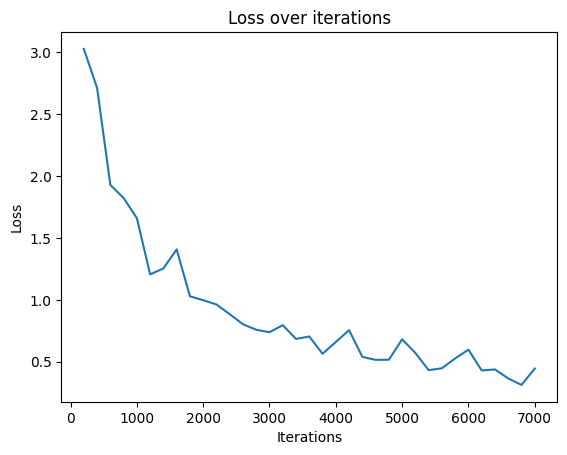

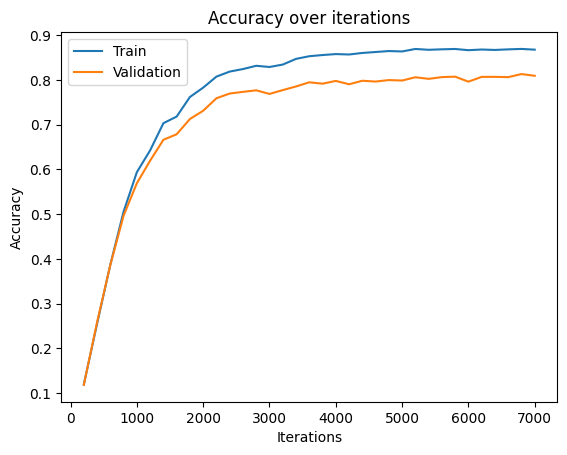

In [ ]:
num_classes = 27

# Load pre-trained VGG16 model
vgg16 = models.vgg16(pretrained=True).to(torch.float)

# Modify the first convolutional layer to accept 1 channel input
vgg16.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

# Optionally add an adaptive pooling layer to resize feature maps
#vgg16.features = nn.Sequential(
    #nn.AdaptiveAvgPool2d((128, 33)),
    #vgg16.features,
#)

# Modify the classifier to output 27 classes
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, 27)

vgg16.to(device)
train_model(vgg16, train_data_tensor, valid_data_tensor, batch_size=64, learning_rate=0.00005, weight_decay = 0.00001, num_epochs=20, plot_every=200)

# Performance Analysis

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

NameError: name 'vgg16' is not defined

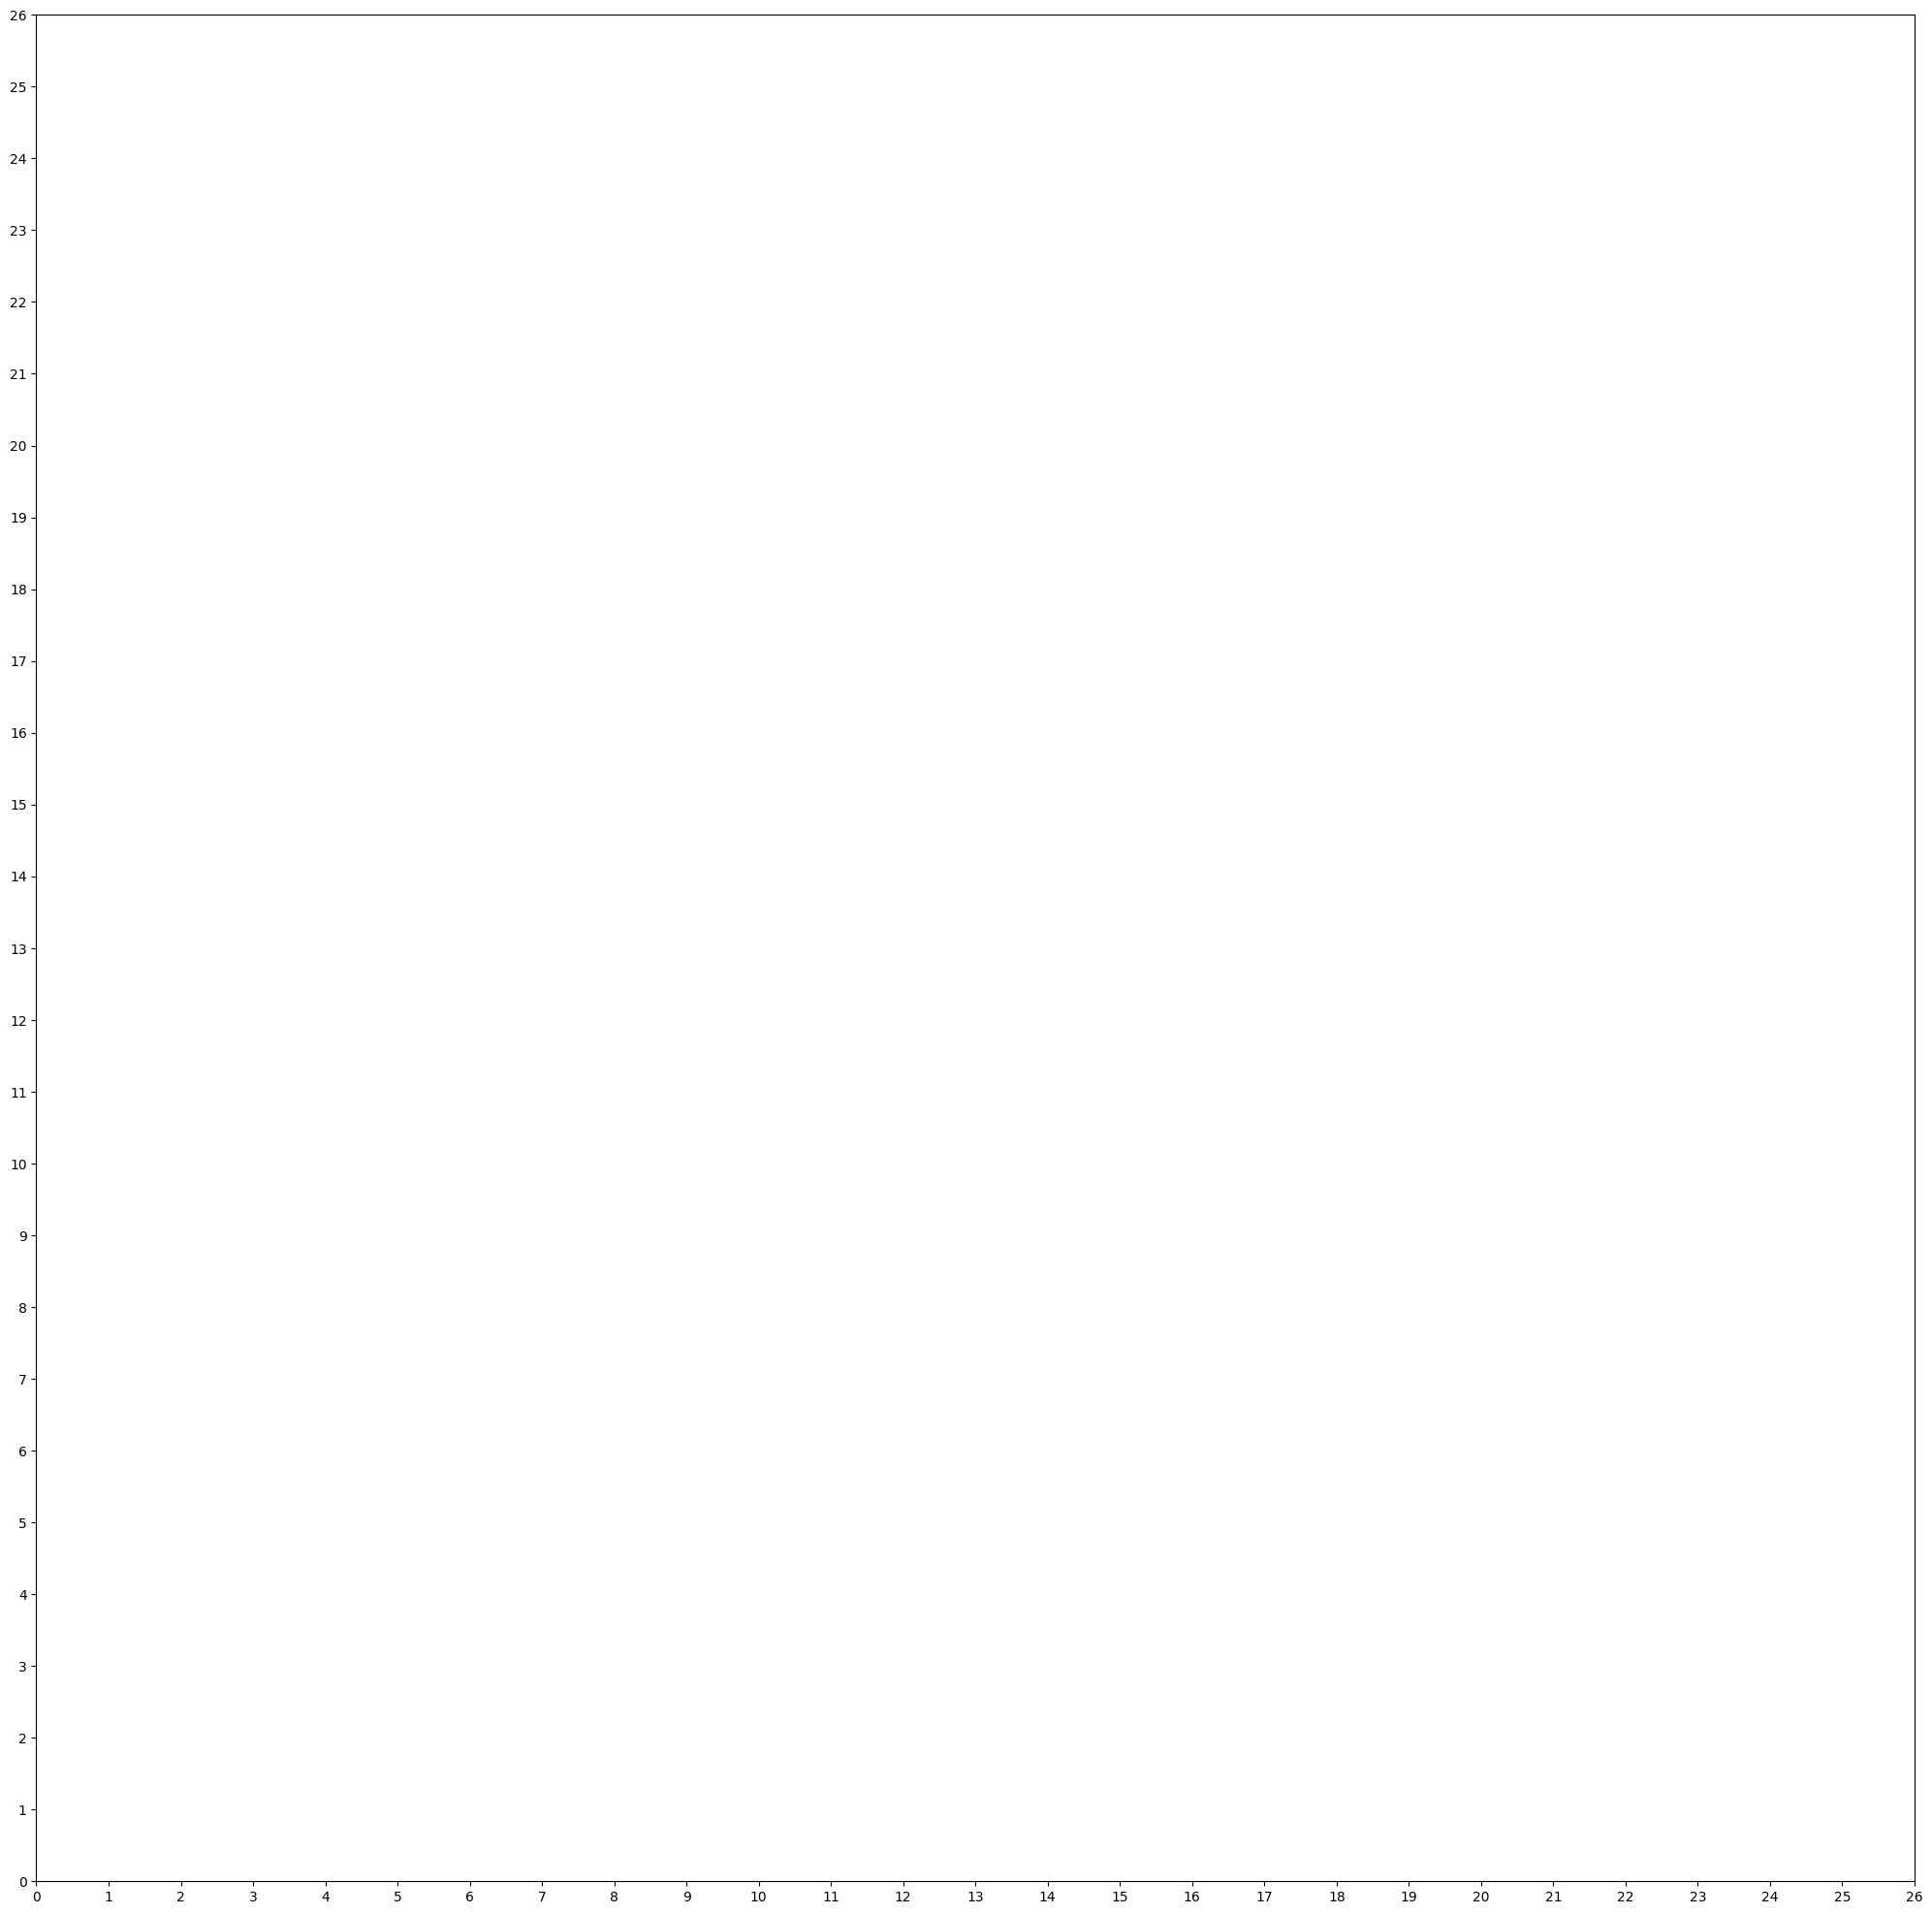

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def get_prediction(model, data, sample=1000):
    loader = torch.utils.data.DataLoader(data, batch_size=sample, shuffle=True)
    for X, t in loader:
        z = model(X)
        y = torch.sigmoid(z)
        break
    return y, t

fig, ax = plt.subplots(figsize=(25, 25))
ax.set(
    xticks=np.arange(27),
    yticks=np.arange(27)
)
y, t = get_prediction(vgg16, test_data_tensor, sample=5000)
y = torch.argmax(y, axis=1)
t = torch.argmax(t, axis=1)
y = y.to('cpu').numpy()
t = t.to('cpu').numpy()
cm = confusion_matrix(t, y)
cmp = ConfusionMatrixDisplay(cm, display_labels=list("ABCDEFGHIJKLMNOPQRSTUVWXYZ") + ["SPACE"])
cmp.plot(ax=ax)
ax.set_title("Confusion Matrix (Val Data)")

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (27,) and arg 1 with shape (21,).

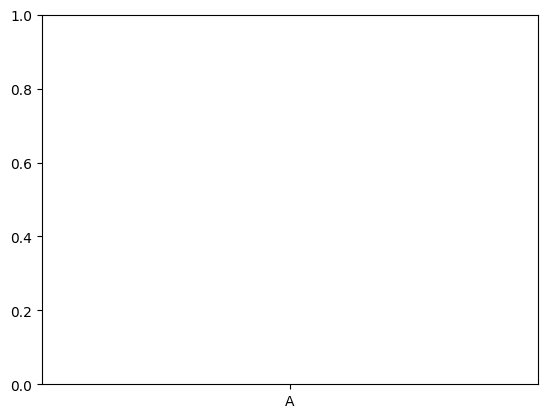

In [ ]:
classification_rate = cm.diagonal() / cm.sum(axis=1)
plt.bar(list("ABCDEFGHIJKLMNOPQRSTUVWXYZ") + ['SPACE'], classification_rate)
plt.title("Correct Classification Rate (Val Data, CNN)")

From the above we see that the CNN performs relatively well, but has particularly poor performance on letters A, F, and R.

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score